In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from typing import Dict, List, Any

# Kaggle paths
BASE_CSV_PATH = '/kaggle/input/ecg-data-thesis/ecg-csv/ecg-csv'
BASE_ECG_PATH = '/kaggle/input/ecg-data-thesis/ecg_individual/ecg_individual'

# Disease classes
DISEASE_CLASSES = [
    'Atelectasis',
    'Cardiomegaly',
    'Edema',
    'Lung Opacity',
    'Pleural Effusion'
]

SPLIT_ECG_FOLDERS = {
    'train': 'train',
    'val': 'val',
    'test': 'test'
}


def load_ecg_dataset(class_name: str) -> Dict[str, Dict[str, Any]]:
    """
    Load ECG dataset for a specific class (disease condition).
    Returns dictionary with train/val/test splits containing dataframes and verified ECG file paths.
    """
    if not os.path.exists(BASE_CSV_PATH):
        print(f"Error: Base CSV path not found: {BASE_CSV_PATH}")
        return {}

    result_data = {}
    condition_csv_path = os.path.join(BASE_CSV_PATH, class_name)

    print(f"\n--- Starting ECG Data Load for Class: {class_name} ---")

    for split_type, ecg_folder in SPLIT_ECG_FOLDERS.items():
        csv_filename = f'{class_name}_{split_type}.csv'
        csv_path = os.path.join(condition_csv_path, csv_filename)

        df = None
        verified_paths = []

        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path)
                print(f"  Loaded {split_type} CSV: {len(df):,} entries")

                base_ecg_folder = os.path.join(BASE_ECG_PATH, ecg_folder, 'files')

                if os.path.exists(base_ecg_folder):
                    for index, row in df.iterrows():
                        ecg_path = str(row['ecg_path']).replace('\\', '/')

                        path_parts = ecg_path.split('/')
                        if len(path_parts) >= 4:
                            patient_id = path_parts[-4]
                            subject_id = path_parts[-3]
                            study_id = path_parts[-2]
                            ecg_id = path_parts[-1]

                            for ext in ['.npy', '']:
                                full_ecg_path = os.path.join(base_ecg_folder, patient_id, subject_id, study_id, f"{ecg_id}{ext}")
                                if os.path.exists(full_ecg_path):
                                    verified_paths.append(full_ecg_path)
                                    break

                print(f"  Verified ECG files: {len(verified_paths):,}")

            except Exception as e:
                print(f"  Error processing {csv_path}: {e}")

        else:
            print(f"  Warning: CSV not found for {split_type} at {csv_path}")

        result_data[split_type] = {
            'df': df,
            'ecg_paths': verified_paths
        }

    print(f"Successfully Loaded ECG Dataset for {class_name}")
    return result_data

class ECGDataset(Dataset):
    def __init__(self, dataframe, ecg_paths, condition_name, transform=None):
        self.dataframe = dataframe
        self.ecg_paths = ecg_paths
        self.condition_name = condition_name
        self.transform = transform

    def __len__(self):
        return len(self.ecg_paths)

    def __getitem__(self, idx):
        ecg_path = self.ecg_paths[idx]

        # Load ECG
        try:
            ecg = np.load(ecg_path)
        except:
            ecg = np.loadtxt(ecg_path)

        ecg_tensor = torch.tensor(ecg, dtype=torch.float32)

        if ecg_tensor.ndim == 3:
            if ecg_tensor.shape[0] == 1:
                ecg_tensor = ecg_tensor.squeeze(0)
            else:
                raise ValueError(f"Unexpected ECG shape: {ecg_tensor.shape}")
        if ecg_tensor.ndim == 2:
            if ecg_tensor.shape[0] == 5000 and ecg_tensor.shape[1] == 12:
                ecg_tensor = ecg_tensor.permute(1, 0)
            elif ecg_tensor.shape[0] == 12 and ecg_tensor.shape[1] == 5000:
                pass
            else:
                raise ValueError(f"Unexpected ECG shape: {ecg_tensor.shape}")
        else:
            raise ValueError(f"Unexpected ECG tensor ndim: {ecg_tensor.ndim}")

        ecg_id = os.path.basename(ecg_path).replace('.npy', '')
        matching_rows = self.dataframe[self.dataframe['ecg_path'].str.contains(ecg_id, na=False)]
        if not matching_rows.empty:
            label = torch.tensor(matching_rows.iloc[0][self.condition_name], dtype=torch.float32)
        else:
            label = torch.tensor(0.0, dtype=torch.float32)

        return ecg_tensor, label


In [ ]:
# ECG Dataset CSV Analysis & Visualization Functions

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

# List of disease conditions in ECG dataset
ECG_CONDITIONS = [
    'Atelectasis',
    'Cardiomegaly',
    'Edema',
    'Lung Opacity',
    'Pleural Effusion'
]

# Base path to CSVs
ECG_DATASET_BASE_PATH = '/kaggle/input/ecg-data-thesis/ecg-csv/ecg-csv'

# ----------------------------------------------------------------
def analyze_ecg_class_csv_stats(class_name: str, dataset_base_path: str = ECG_DATASET_BASE_PATH) -> Optional[pd.DataFrame]:
    """
    Loads and provides statistical analysis for train/val/test CSVs for a given class.
    Returns the train_df for visualization purposes.
    """
    print("="*70)
    print(f"ECG STATISTICAL ANALYSIS FOR CLASS: {class_name.upper()}")
    print("="*70)

    class_path = os.path.join(dataset_base_path, class_name)
    train_df = None

    for split in ['train', 'val', 'test']:
        csv_file = f"{class_name}_{split}.csv"
        csv_path = os.path.join(class_path, csv_file)
        df = None
        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path)
                if split == 'train':
                    train_df = df
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")

        print(f"\n--- {split.upper()} SET ({csv_file}) ---")
        if df is not None:
            print(f"Total entries: {len(df):,}")
            present_conditions = [c for c in ECG_CONDITIONS if c in df.columns]
            if present_conditions:
                print("\nCondition label distribution:")
                for condition in present_conditions:
                    pos = int((df[condition] == 1).sum())
                    neg = int((df[condition] == 0).sum())
                    total_labeled = pos + neg
                    pct_pos = (pos / len(df))*100 if len(df) > 0 else 0.0
                    print(f"  • {condition:15}: Pos={pos:,} ({pct_pos:.1f}%), Neg={neg:,}, Total Labeled={total_labeled:,}")
            else:
                print("No standard condition columns found for distribution analysis.")
        else:
            print(f"Warning: CSV not found at {csv_path}")

    return train_df

# ----------------------------------------------------------------
def visualize_ecg_training_label_distribution(class_name: str, train_df: pd.DataFrame):
    """
    Visualizes the label distribution of 0 and 1 for all conditions in the training set.
    """
    if train_df is None:
        print("Training dataframe is missing. Cannot plot distribution.")
        return

    print("\n" + "~"*70)
    print(f"ECG TRAINING SET LABEL DISTRIBUTION FOR: {class_name.upper()}")
    print("~"*70)

    condition_cols = [c for c in ECG_CONDITIONS if c in train_df.columns]
    if not condition_cols:
        print("No condition columns found in training set.")
        return

    # Count occurrences of 0 and 1 across all conditions
    label_counts = train_df[condition_cols].apply(pd.Series.value_counts).sum(axis=1)

    # Ensure we have both 0 and 1 keys
    labels_to_plot = pd.Series(0, index=[0.0, 1.0])
    for label in label_counts.index:
        if label in labels_to_plot.index and not np.isnan(label):
            labels_to_plot[label] = label_counts[label]

    labels_to_plot = labels_to_plot.astype(int).sort_index()
    print(f"\nTraining Set total label counts: \n{labels_to_plot.to_string()}")

    # --- Plotting ---
    save_path = f"{class_name.lower()}_ecg_label_distribution.png"
    plt.figure(figsize=(8,6))
    colors = {0.0: '#FF6B6B', 1.0: '#4ECDC4'}
    x_labels = {0.0: "0 (Negative)", 1.0: "1 (Positive)"}

    plt.bar([x_labels[l] for l in labels_to_plot.index],
            labels_to_plot.values,
            color=[colors[l] for l in labels_to_plot.index])

    plt.title(f"ECG Training Set Label Distribution - {class_name}", fontsize=14, fontweight='bold')
    plt.xlabel("Label Value", fontsize=12)
    plt.ylabel("Total Count Across All Condition Columns", fontsize=12)
    plt.xticks(rotation=15, ha='right')

    for i, v in enumerate(labels_to_plot.values):
        plt.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved as '{save_path}'")





# 1D CNN - Atelectasis

Epoch 3/15 | Time: 9.88s
Train -> Loss: 0.6908, Acc: 0.5375, F1: 0.5447, AUC: 0.5534
Val   -> Loss: 0.6691, Acc: 0.5906, F1: 0.6618, AUC: 0.6142


Early stopping.


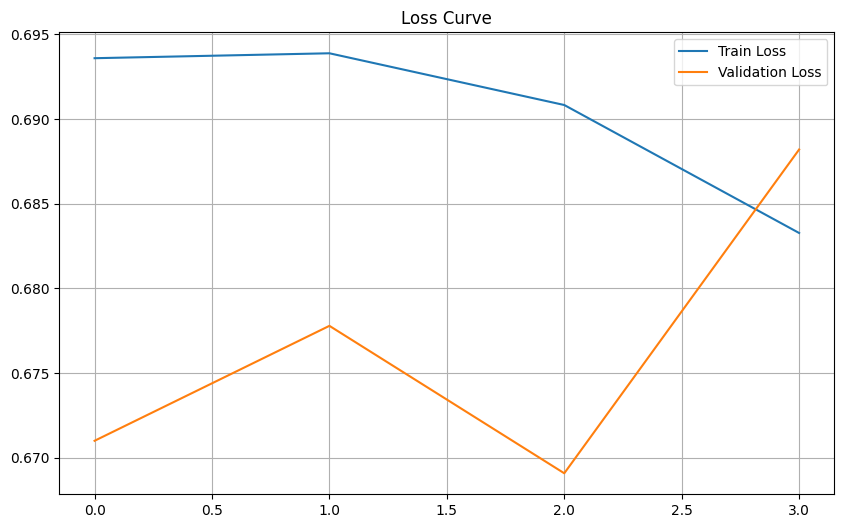


Final Test Metrics
Loss: 0.6781, Acc: 0.6104, F1: 0.7094, AUC: 0.5850


Testing: 100%|██████████| 67/67 [00:03<00:00, 19.40it/s]


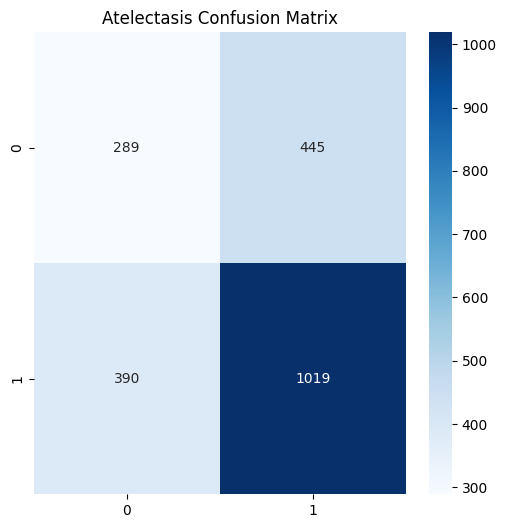

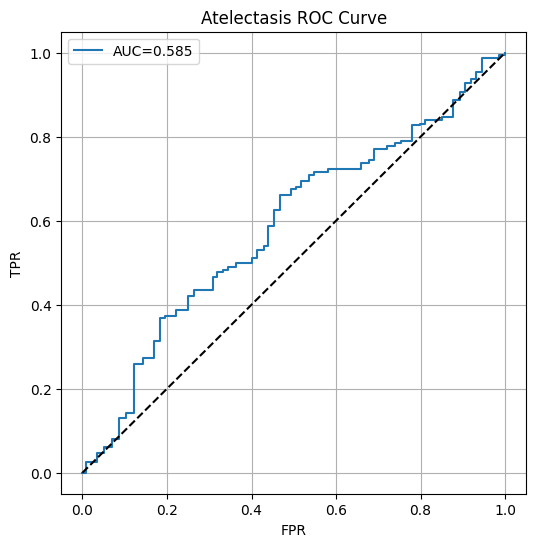


Classification Report:

              precision    recall  f1-score   support

    Negative       0.43      0.39      0.41       734
    Positive       0.70      0.72      0.71      1409

    accuracy                           0.61      2143
   macro avg       0.56      0.56      0.56      2143
weighted avg       0.60      0.61      0.61      2143



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D CNN MODEL
class ECGCNN1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Atelectasis"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCNN1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_cnn1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_cnn1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_cnn1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN - Cardiomegaly

Epoch 4/15 | Time: 13.67s
Train -> Loss: 0.6709, Acc: 0.5875, F1: 0.5670, AUC: 0.6245
Val   -> Loss: 0.6744, Acc: 0.5653, F1: 0.5971, AUC: 0.6239


Early stopping.


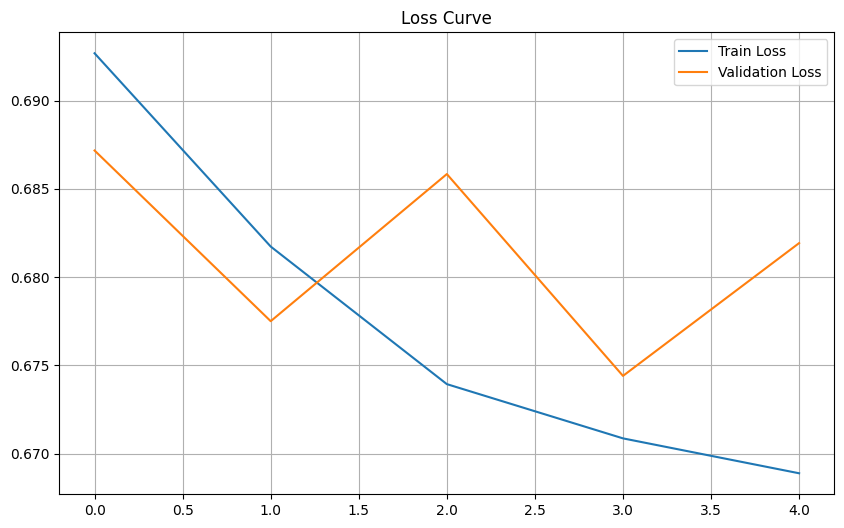


Final Test Metrics
Loss: 0.6766, Acc: 0.5676, F1: 0.5542, AUC: 0.6264


Testing: 100%|██████████| 80/80 [00:04<00:00, 18.78it/s]


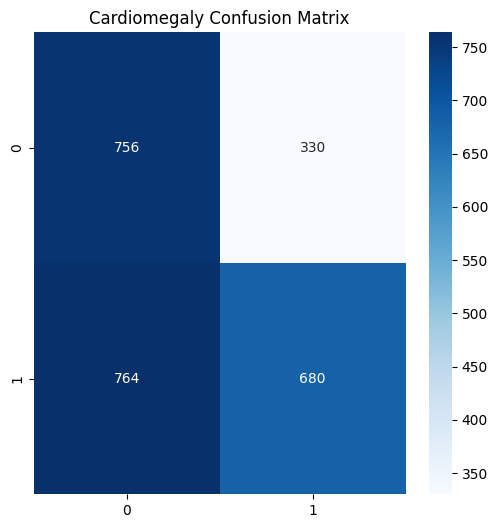

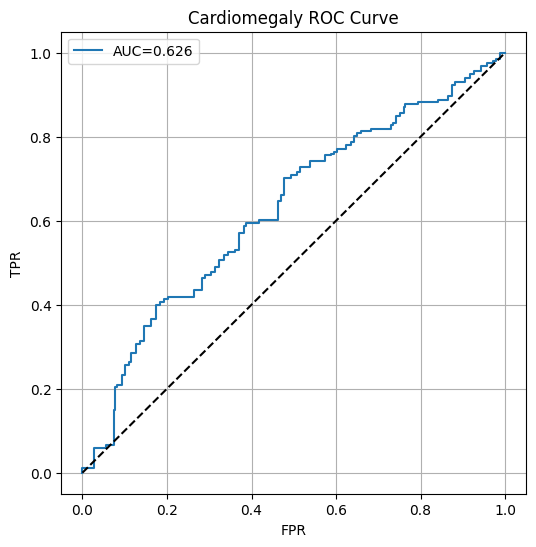


Classification Report:

              precision    recall  f1-score   support

    Negative       0.50      0.70      0.58      1086
    Positive       0.67      0.47      0.55      1444

    accuracy                           0.57      2530
   macro avg       0.59      0.58      0.57      2530
weighted avg       0.60      0.57      0.57      2530



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D CNN MODEL
class ECGCNN1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Cardiomegaly"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCNN1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_cnn1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_cnn1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_cnn1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))

# 1D CNN - Edema

Epoch 8/15 | Time: 12.02s
Train -> Loss: 0.6778, Acc: 0.5721, F1: 0.5762, AUC: 0.6022
Val   -> Loss: 0.6713, Acc: 0.5908, F1: 0.4904, AUC: 0.6231


Early stopping.


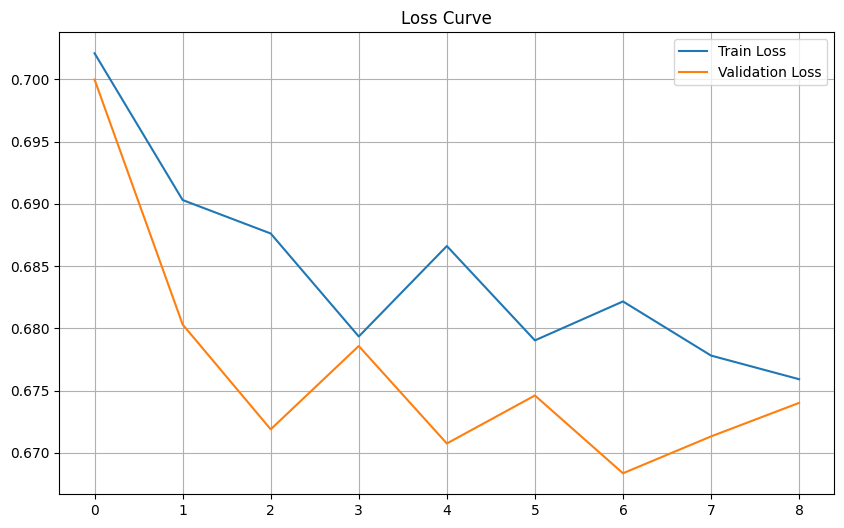


Final Test Metrics
Loss: 0.6831, Acc: 0.5951, F1: 0.5137, AUC: 0.6100


Testing: 100%|██████████| 70/70 [00:03<00:00, 19.45it/s]


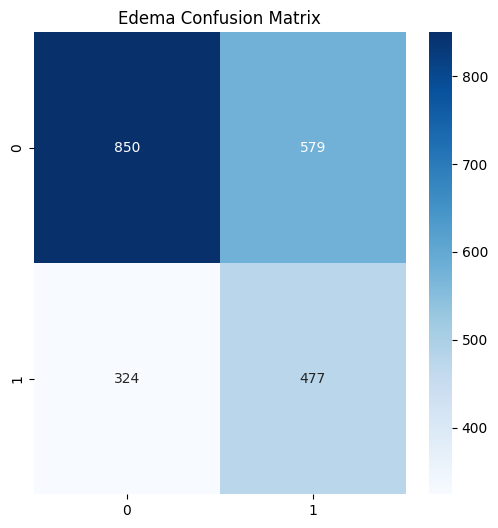

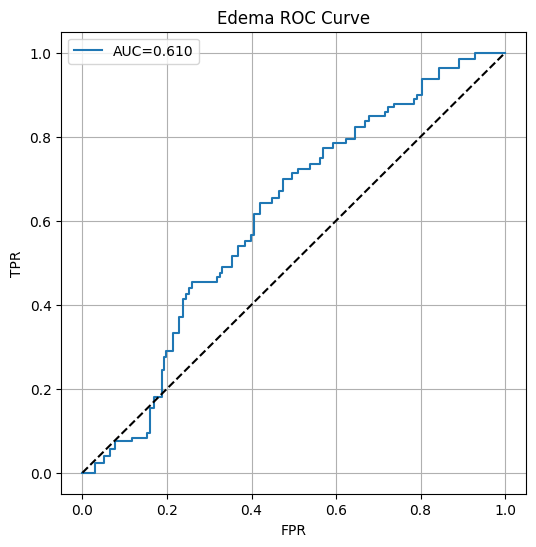


Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.59      0.65      1429
    Positive       0.45      0.60      0.51       801

    accuracy                           0.60      2230
   macro avg       0.59      0.60      0.58      2230
weighted avg       0.63      0.60      0.60      2230



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D CNN MODEL
class ECGCNN1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Edema"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCNN1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_cnn1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_cnn1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_cnn1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN - Lung Opacity

Epoch 5/15 | Time: 10.69s
Train -> Loss: 0.6827, Acc: 0.5559, F1: 0.5333, AUC: 0.5793
Val   -> Loss: 0.6684, Acc: 0.6029, F1: 0.6512, AUC: 0.6507


Early stopping.


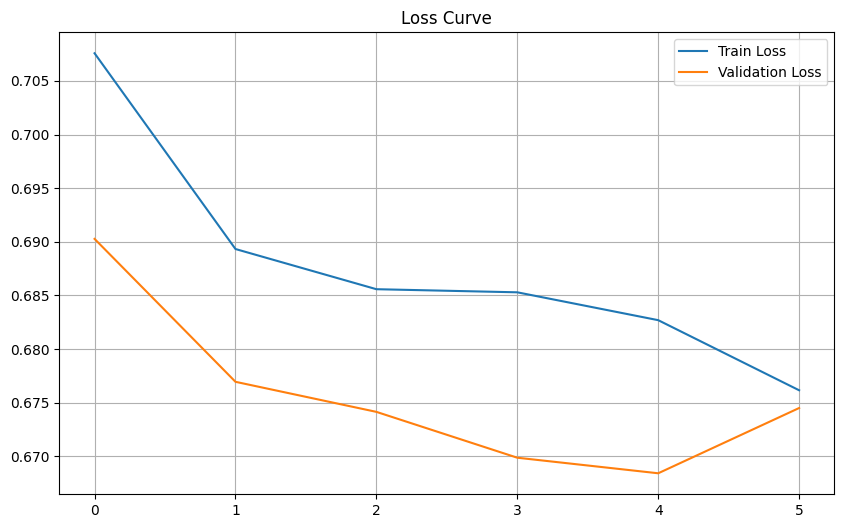


Final Test Metrics
Loss: 0.6833, Acc: 0.5111, F1: 0.5243, AUC: 0.5993


Testing: 100%|██████████| 67/67 [00:03<00:00, 20.64it/s]


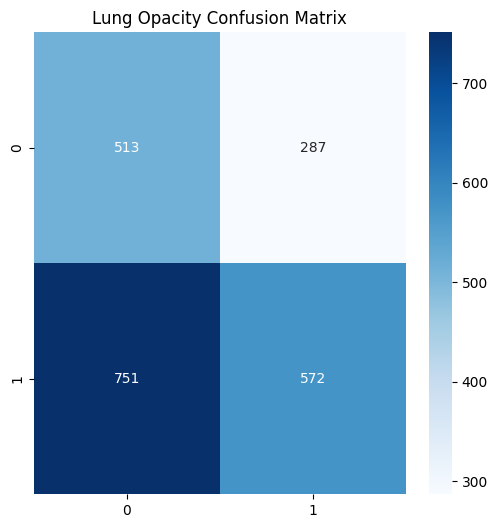

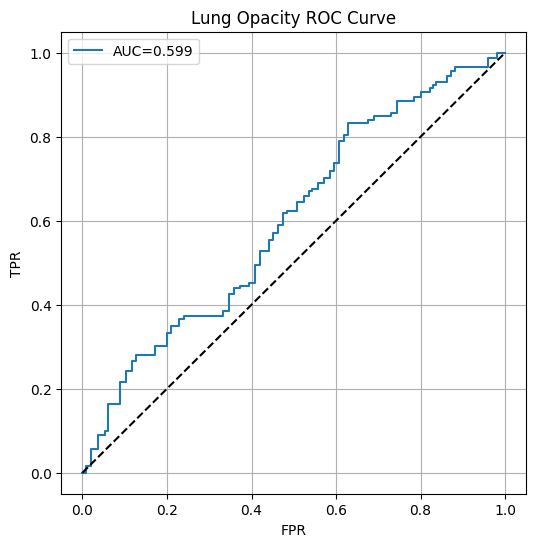


Classification Report:

              precision    recall  f1-score   support

    Negative       0.41      0.64      0.50       800
    Positive       0.67      0.43      0.52      1323

    accuracy                           0.51      2123
   macro avg       0.54      0.54      0.51      2123
weighted avg       0.57      0.51      0.51      2123



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D CNN MODEL
class ECGCNN1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS with tqdm bars

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Lung Opacity"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCNN1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_cnn1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_cnn1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_cnn1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN - Pleural Effusion

Epoch 12/15 | Time: 17.88s
Train -> Loss: 0.6747, Acc: 0.5864, F1: 0.5651, AUC: 0.6115
Val   -> Loss: 0.6635, Acc: 0.6367, F1: 0.6079, AUC: 0.6633


Early stopping.


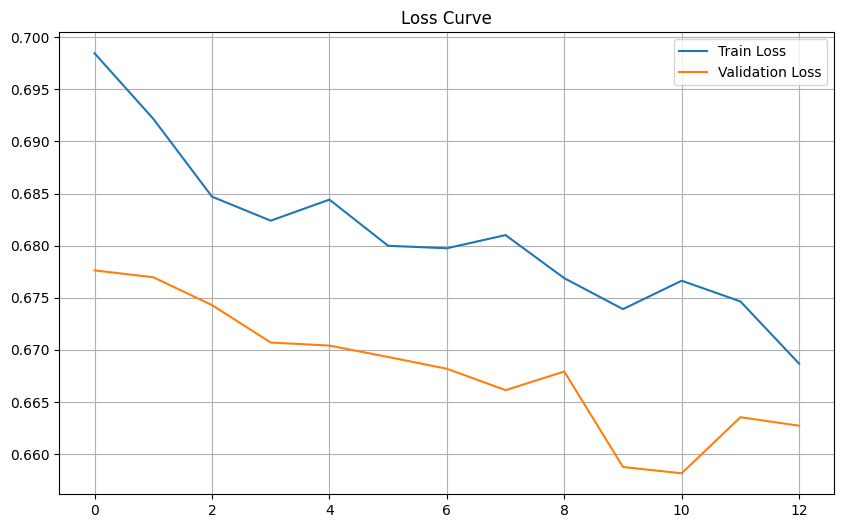


Final Test Metrics
Loss: 0.6808, Acc: 0.5743, F1: 0.5414, AUC: 0.6063


Testing: 100%|██████████| 99/99 [00:05<00:00, 16.99it/s]


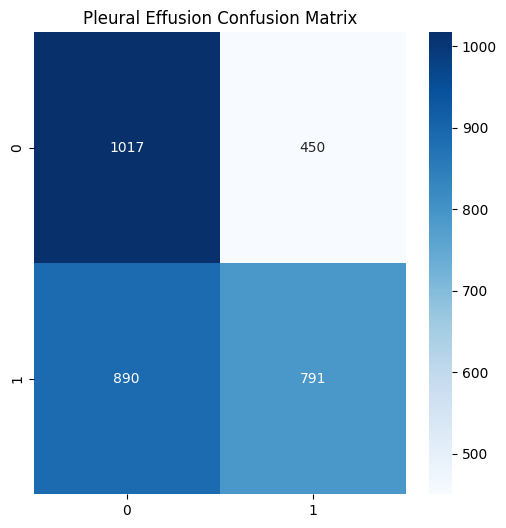

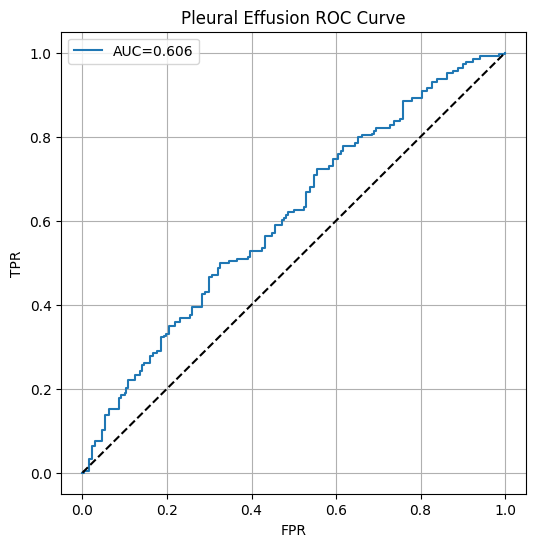


Classification Report:

              precision    recall  f1-score   support

    Negative       0.53      0.69      0.60      1467
    Positive       0.64      0.47      0.54      1681

    accuracy                           0.57      3148
   macro avg       0.59      0.58      0.57      3148
weighted avg       0.59      0.57      0.57      3148



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D CNN MODEL
class ECGCNN1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Pleural Effusion"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCNN1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_cnn1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_cnn1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_cnn1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN+LSTM - Atelecasis

Epoch 12/15 | Time: 10.58s
Train -> Loss: 0.6771, Acc: 0.5703, F1: 0.5727, AUC: 0.5983
Val   -> Loss: 0.6961, Acc: 0.5263, F1: 0.5263, AUC: 0.6341


Early stopping.


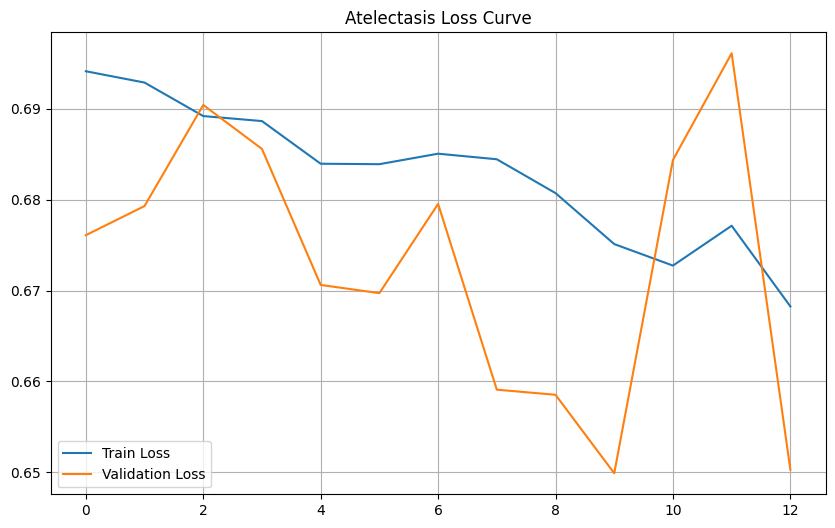


Final Test Metrics
Loss: 0.6651, Acc: 0.5735, F1: 0.6554, AUC: 0.6011


Testing: 100%|██████████| 67/67 [00:03<00:00, 19.46it/s]


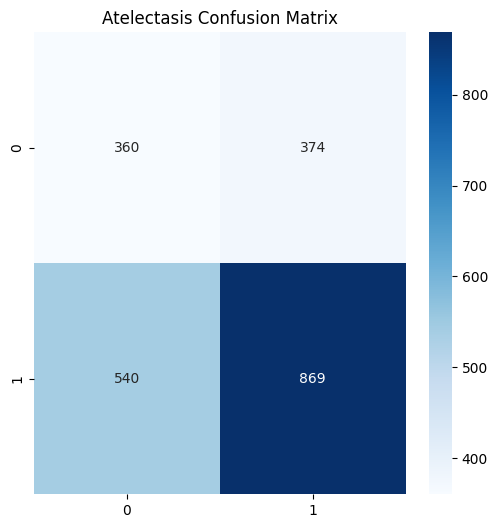

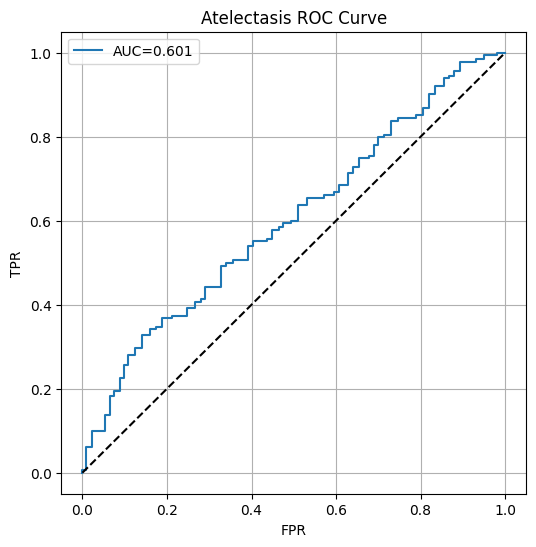


Classification Report:

              precision    recall  f1-score   support

    Negative       0.40      0.49      0.44       734
    Positive       0.70      0.62      0.66      1409

    accuracy                           0.57      2143
   macro avg       0.55      0.55      0.55      2143
weighted avg       0.60      0.57      0.58      2143



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# CNN-LSTM HYBRID MODEL (CRNN)
class ECGCRNN(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1, dropout=0.5):
        super(ECGCRNN, self).__init__()
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(3, stride=2, padding=1)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        batch_size, channels, seq_len = x.shape
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)

        x = self.dropout(lstm_out)
        x = self.fc(x)

        return x.squeeze() if self.fc.out_features == 1 else x

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Atelectasis"
    loaded_data = load_ecg_dataset(target_class)  # implement accordingly

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCRNN(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_crnn.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_crnn_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title(f"{target_class} Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_crnn.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN + LSTM - Cardiomegaly

Epoch 6/15 | Time: 14.23s
Train -> Loss: 0.6539, Acc: 0.6157, F1: 0.6279, AUC: 0.6604
Val   -> Loss: 0.6602, Acc: 0.6014, F1: 0.6576, AUC: 0.6325


Early stopping.


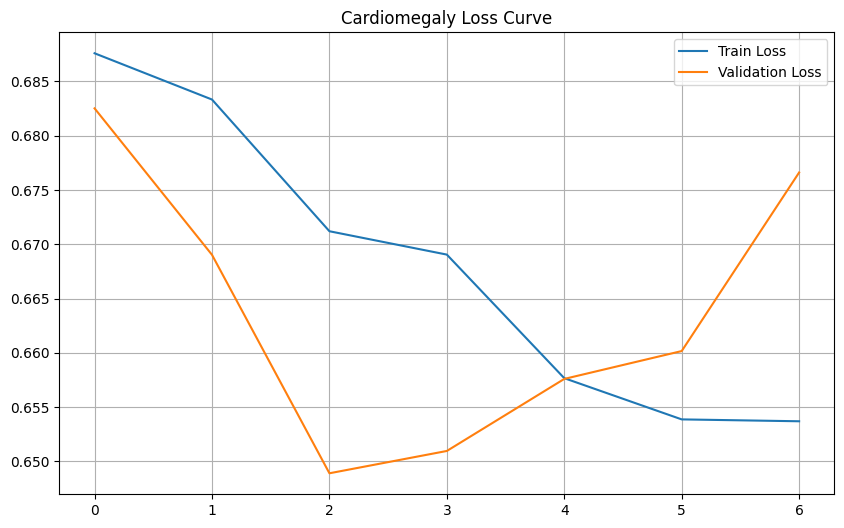


Final Test Metrics
Loss: 0.6706, Acc: 0.6115, F1: 0.6621, AUC: 0.6091


Testing: 100%|██████████| 80/80 [00:04<00:00, 18.91it/s]


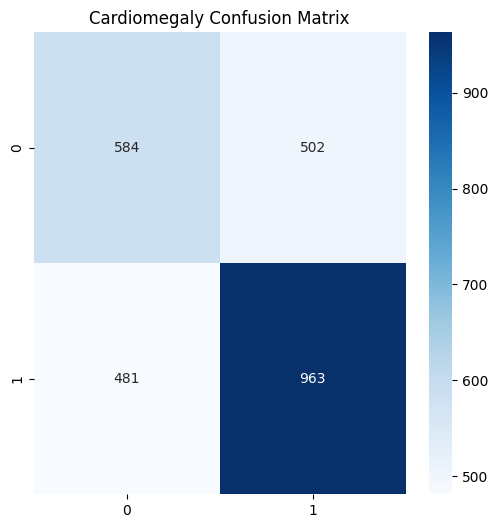

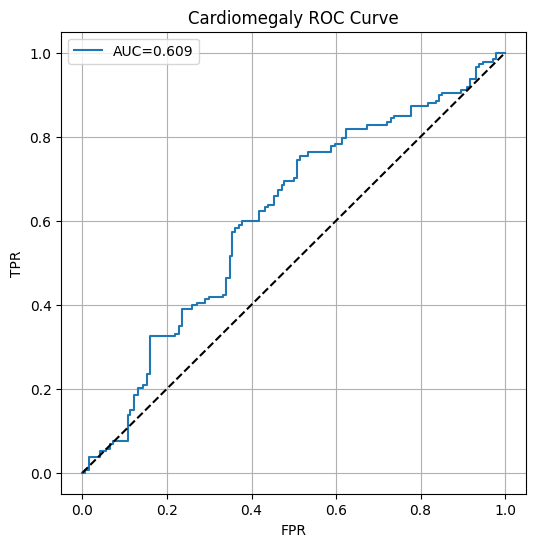


Classification Report:

              precision    recall  f1-score   support

    Negative       0.55      0.54      0.54      1086
    Positive       0.66      0.67      0.66      1444

    accuracy                           0.61      2530
   macro avg       0.60      0.60      0.60      2530
weighted avg       0.61      0.61      0.61      2530



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# CNN-LSTM HYBRID MODEL (CRNN)
class ECGCRNN(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1, dropout=0.5):
        super(ECGCRNN, self).__init__()
        # CNN Backbone
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(3, stride=2, padding=1)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # bidirectional

    def forward(self, x):
        # CNN
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        batch_size, channels, seq_len = x.shape
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)
        # Classification
        x = self.dropout(lstm_out)
        x = self.fc(x)

        return x.squeeze() if self.fc.out_features == 1 else x

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))



# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Cardiomegaly"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCRNN(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_crnn.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_crnn_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title(f"{target_class} Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_crnn.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN + LSTM - Edema

Epoch 6/15 | Time: 14.13s
Train -> Loss: 0.6698, Acc: 0.6021, F1: 0.5894, AUC: 0.6273
Val   -> Loss: 0.6565, Acc: 0.6394, F1: 0.4679, AUC: 0.6146


Early stopping.


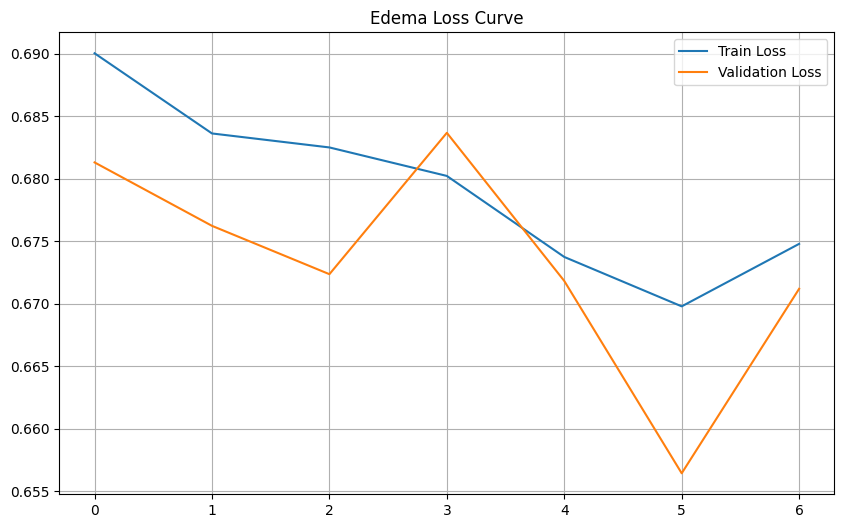


Final Test Metrics
Loss: 0.6946, Acc: 0.5614, F1: 0.5192, AUC: 0.6198


Testing: 100%|██████████| 70/70 [00:03<00:00, 19.58it/s]


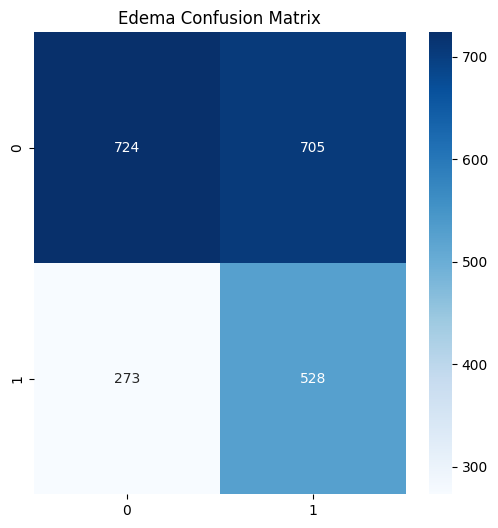

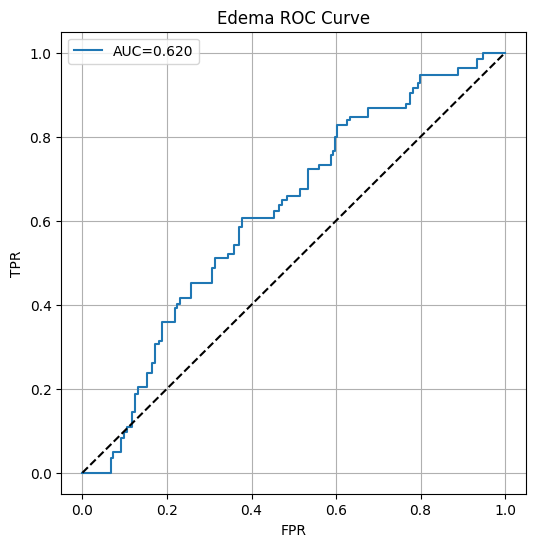


Classification Report:

              precision    recall  f1-score   support

    Negative       0.73      0.51      0.60      1429
    Positive       0.43      0.66      0.52       801

    accuracy                           0.56      2230
   macro avg       0.58      0.58      0.56      2230
weighted avg       0.62      0.56      0.57      2230



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# CNN-LSTM HYBRID MODEL (CRNN)
class ECGCRNN(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1, dropout=0.5):
        super(ECGCRNN, self).__init__()
        # CNN Backbone
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(3, stride=2, padding=1)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        # CNN
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Prepare for LSTM
        batch_size, channels, seq_len = x.shape
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)
        # Classification
        x = self.dropout(lstm_out)
        x = self.fc(x)

        return x.squeeze() if self.fc.out_features == 1 else x

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Edema"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCRNN(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_crnn.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_crnn_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title(f"{target_class} Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_crnn.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN + LSTM - Lung Opacity

Epoch 7/15 | Time: 11.55s
Train -> Loss: 0.6791, Acc: 0.5754, F1: 0.5354, AUC: 0.5959
Val   -> Loss: 0.6846, Acc: 0.5676, F1: 0.5812, AUC: 0.6489


Early stopping.


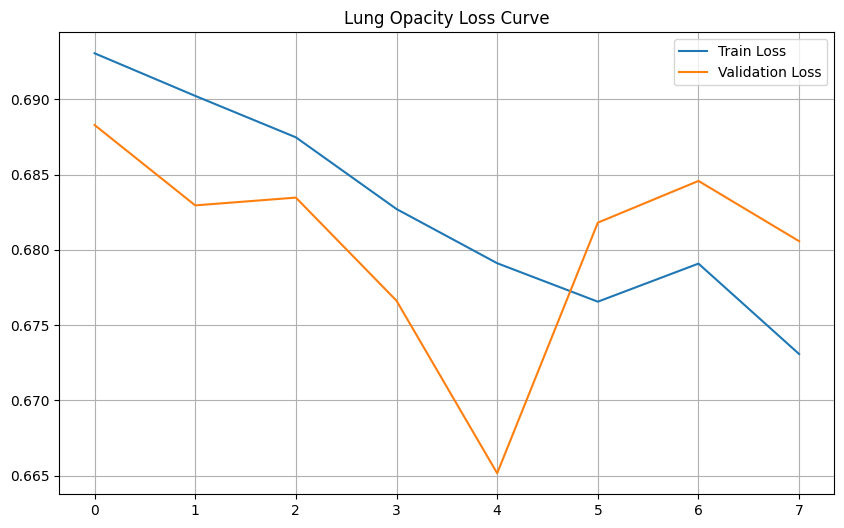


Final Test Metrics
Loss: 0.6790, Acc: 0.6001, F1: 0.6536, AUC: 0.6117


Testing: 100%|██████████| 67/67 [00:03<00:00, 19.60it/s]


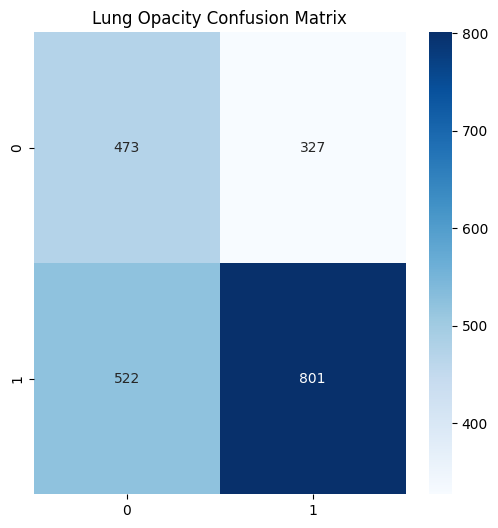

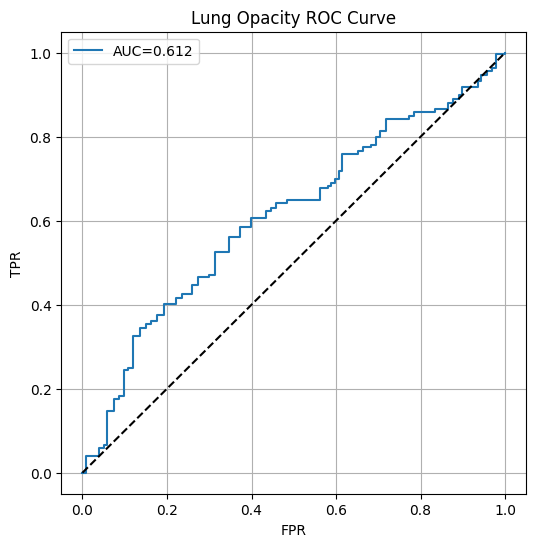


Classification Report:

              precision    recall  f1-score   support

    Negative       0.48      0.59      0.53       800
    Positive       0.71      0.61      0.65      1323

    accuracy                           0.60      2123
   macro avg       0.59      0.60      0.59      2123
weighted avg       0.62      0.60      0.61      2123



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# CNN-LSTM HYBRID MODEL (CRNN)
class ECGCRNN(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1, dropout=0.5):
        super(ECGCRNN, self).__init__()
        # CNN Backbone
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(3, stride=2, padding=1)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        # CNN
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Prepare for LSTM
        batch_size, channels, seq_len = x.shape
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)

        # Classification
        x = self.dropout(lstm_out)
        x = self.fc(x)

        return x.squeeze() if self.fc.out_features == 1 else x

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Lung Opacity"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCRNN(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_crnn.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_crnn_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title(f"{target_class} Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_crnn.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D CNN + LSTM - Pleural Effusion

Epoch 13/15 | Time: 18.23s
Train -> Loss: 0.6556, Acc: 0.6196, F1: 0.6147, AUC: 0.6554
Val   -> Loss: 0.6521, Acc: 0.6143, F1: 0.5828, AUC: 0.6669


Early stopping.


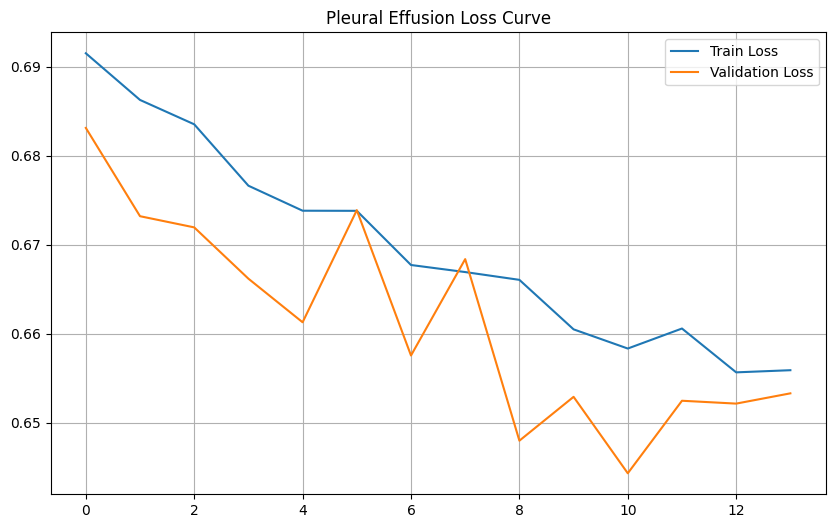


Final Test Metrics
Loss: 0.6728, Acc: 0.5997, F1: 0.6149, AUC: 0.6286


Testing: 100%|██████████| 99/99 [00:05<00:00, 17.29it/s]


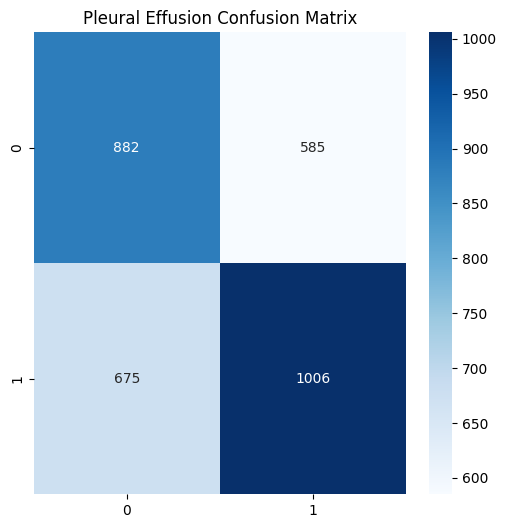

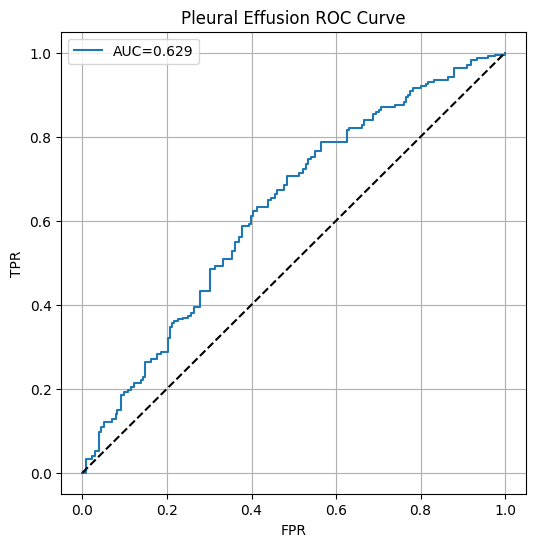


Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      0.60      0.58      1467
    Positive       0.63      0.60      0.61      1681

    accuracy                           0.60      3148
   macro avg       0.60      0.60      0.60      3148
weighted avg       0.60      0.60      0.60      3148



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# CNN-LSTM HYBRID MODEL (CRNN)
class ECGCRNN(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1, dropout=0.5):
        super(ECGCRNN, self).__init__()
        # CNN Backbone
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(3, stride=2, padding=1)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # CNN
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Prepare for LSTM
        batch_size, channels, seq_len = x.shape
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)

        # Classification
        x = self.dropout(lstm_out)
        x = self.fc(x)

        return x.squeeze() if self.fc.out_features == 1 else x

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss / ((loop.n + 1) * inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Pleural Effusion"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGCRNN(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_crnn.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_crnn_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot loss curve
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title(f"{target_class} Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()


    # TESTING

    model.load_state_dict(torch.load(f'best_{target_class}_ecg_crnn.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D ResNet - Atelectasis

Epoch 3/15 | Time: 10.54s
Train -> Loss: 0.6812, Acc: 0.5728, F1: 0.5624, AUC: 0.5955
Val   -> Loss: 0.6903, Acc: 0.5146, F1: 0.5440, AUC: 0.6031


Early stopping.


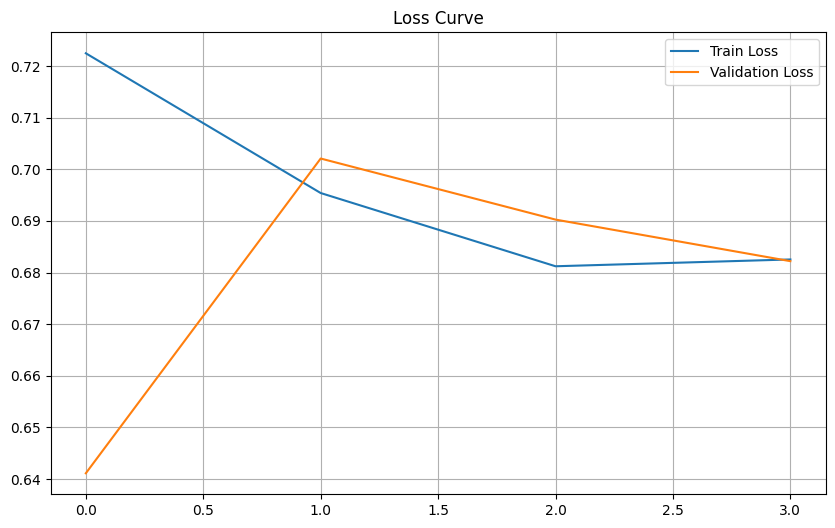


Final Test Metrics
Loss: 0.6456, Acc: 0.6342, F1: 0.7559, AUC: 0.6065


Testing: 100%|██████████| 67/67 [00:03<00:00, 19.76it/s]


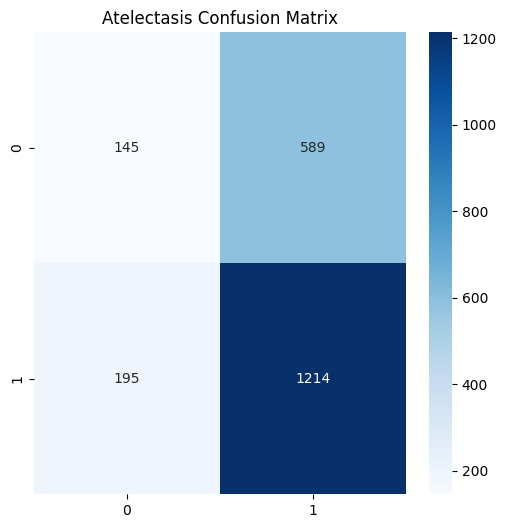

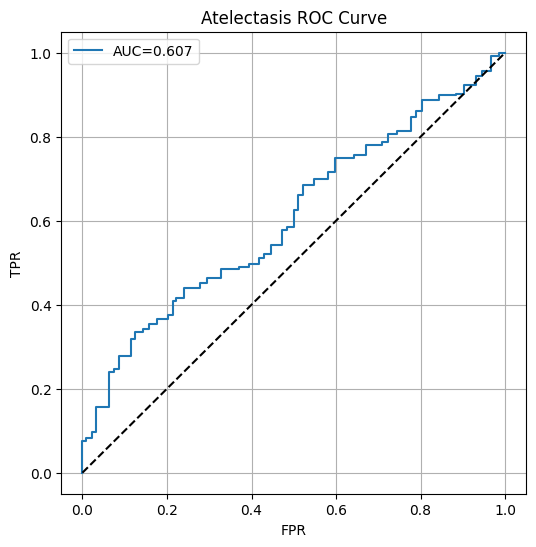


Classification Report:

              precision    recall  f1-score   support

    Negative       0.43      0.20      0.27       734
    Positive       0.67      0.86      0.76      1409

    accuracy                           0.63      2143
   macro avg       0.55      0.53      0.51      2143
weighted avg       0.59      0.63      0.59      2143



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D RESNET MODEL
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ECGResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * BasicBlock1D.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * BasicBlock1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock1D.expansion),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock1D.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Atelectasis"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGResNet1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)

        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_resnet1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_resnet1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()


    # TESTING

    model.load_state_dict(torch.load(f'best_{target_class}_ecg_resnet1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D ResNet - Cardiomegaly


Using device: cuda

--- Starting ECG Data Load for Class: Cardiomegaly ---
  Loaded train CSV: 5,391 entries
  Verified ECG files: 5,391
  Loaded val CSV: 444 entries
  Verified ECG files: 444
  Loaded test CSV: 2,530 entries
  Verified ECG files: 2,530
Successfully Loaded ECG Dataset for Cardiomegaly


Training:  99%|█████████▉| 167/169 [00:14<00:00, 12.45it/s]
                                                           
Epochs:   7%|▋         | 1/15 [00:16<03:46, 16.18s/it]     


Epoch 1/15 | Time: 16.16s
Train -> Loss: 0.6981, Acc: 0.5652, F1: 0.5586, AUC: 0.5845
Val   -> Loss: 0.6572, Acc: 0.6171, F1: 0.6975, AUC: 0.6282
Saved best model with val AUC: 0.6282



Training:  99%|█████████▉| 167/169 [00:13<00:00, 12.65it/s]
                                                           
Epochs:  13%|█▎        | 2/15 [00:30<03:17, 15.22s/it]     


Epoch 2/15 | Time: 14.53s
Train -> Loss: 0.6649, Acc: 0.5995, F1: 0.5797, AUC: 0.6430
Val   -> Loss: 0.6623, Acc: 0.6239, F1: 0.6745, AUC: 0.6421
Saved best model with val AUC: 0.6421



Training:  99%|█████████▉| 167/169 [00:13<00:00, 13.10it/s]
                                                           
Epochs:  20%|██        | 3/15 [00:44<02:55, 14.66s/it]     


Epoch 3/15 | Time: 13.99s
Train -> Loss: 0.6429, Acc: 0.6325, F1: 0.6336, AUC: 0.6836
Val   -> Loss: 0.6734, Acc: 0.5698, F1: 0.5996, AUC: 0.6406



Training:  99%|█████████▉| 167/169 [00:13<00:00, 11.87it/s]
                                                           
Epochs:  27%|██▋       | 4/15 [00:59<02:40, 14.61s/it]     


Epoch 4/15 | Time: 14.52s
Train -> Loss: 0.6358, Acc: 0.6448, F1: 0.6398, AUC: 0.6956
Val   -> Loss: 0.7143, Acc: 0.5270, F1: 0.4952, AUC: 0.6461
Saved best model with val AUC: 0.6461



Training: 100%|██████████| 169/169 [00:14<00:00, 14.08it/s]
                                                           
Epochs:  33%|███▎      | 5/15 [01:14<02:30, 15.00s/it]     


Epoch 5/15 | Time: 15.69s
Train -> Loss: 0.6250, Acc: 0.6492, F1: 0.6593, AUC: 0.7056
Val   -> Loss: 0.7201, Acc: 0.5518, F1: 0.5134, AUC: 0.6562
Saved best model with val AUC: 0.6562



Training:  99%|█████████▉| 167/169 [00:13<00:00, 12.32it/s]
                                                           
Epochs:  40%|████      | 6/15 [01:29<02:13, 14.86s/it]     


Epoch 6/15 | Time: 14.58s
Train -> Loss: 0.6217, Acc: 0.6563, F1: 0.6609, AUC: 0.7105
Val   -> Loss: 0.7283, Acc: 0.5270, F1: 0.5047, AUC: 0.6366



Training: 100%|██████████| 169/169 [00:13<00:00, 12.85it/s]
                                                           
Epochs:  47%|████▋     | 7/15 [01:43<01:57, 14.66s/it]     


Epoch 7/15 | Time: 14.22s
Train -> Loss: 0.6119, Acc: 0.6687, F1: 0.6611, AUC: 0.7280
Val   -> Loss: 0.6729, Acc: 0.5946, F1: 0.6484, AUC: 0.6566
Saved best model with val AUC: 0.6566



Training: 100%|██████████| 169/169 [00:13<00:00, 13.94it/s]
                                                           
Epochs:  53%|█████▎    | 8/15 [01:57<01:41, 14.46s/it]     


Epoch 8/15 | Time: 14.03s
Train -> Loss: 0.5883, Acc: 0.6856, F1: 0.6909, AUC: 0.7520
Val   -> Loss: 0.7470, Acc: 0.5878, F1: 0.6013, AUC: 0.6347



Training: 100%|██████████| 169/169 [00:14<00:00, 12.69it/s]
                                                           
Epochs:  60%|██████    | 9/15 [02:13<01:28, 14.75s/it]     


Epoch 9/15 | Time: 15.40s
Train -> Loss: 0.5912, Acc: 0.6835, F1: 0.6842, AUC: 0.7506
Val   -> Loss: 0.7216, Acc: 0.5631, F1: 0.5670, AUC: 0.6362



Training:  99%|█████████▉| 167/169 [00:13<00:00, 13.28it/s]
                                                           
Epochs:  60%|██████    | 9/15 [02:28<01:38, 16.45s/it]     



Epoch 10/15 | Time: 14.84s
Train -> Loss: 0.5734, Acc: 0.6980, F1: 0.6905, AUC: 0.7697
Val   -> Loss: 0.7401, Acc: 0.5676, F1: 0.5949, AUC: 0.6216
Early stopping.


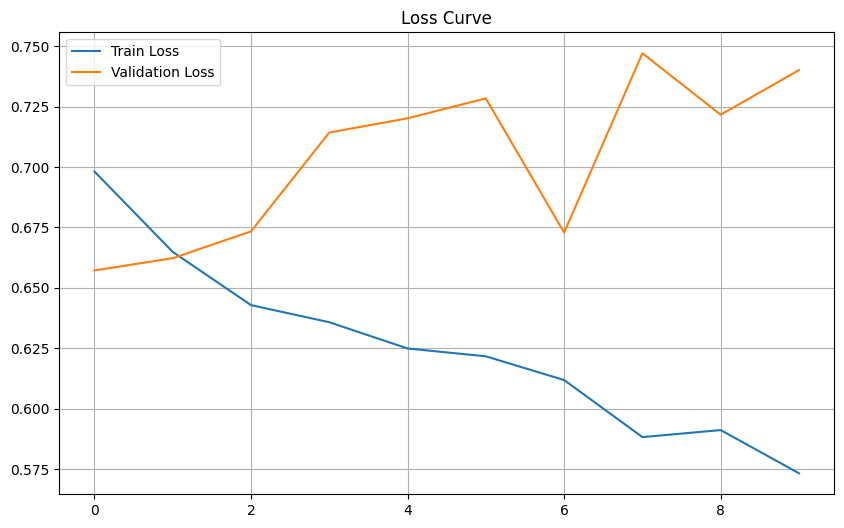


Final Test Metrics
Loss: 0.6448, Acc: 0.6154, F1: 0.6307, AUC: 0.6811


Testing: 100%|██████████| 80/80 [00:04<00:00, 18.82it/s]


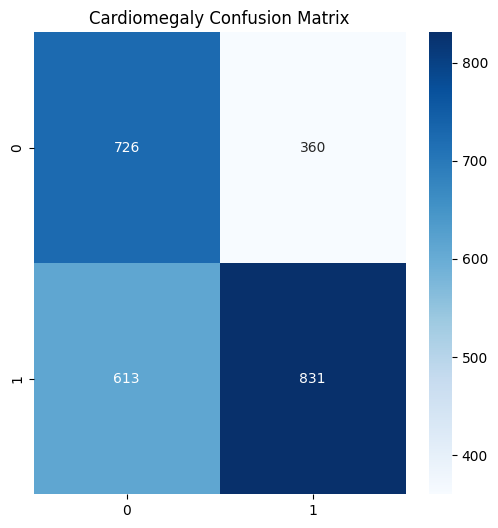

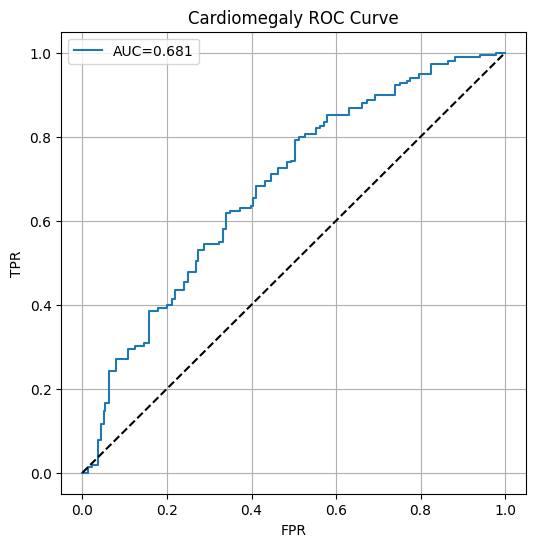


Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60      1086
    Positive       0.70      0.58      0.63      1444

    accuracy                           0.62      2530
   macro avg       0.62      0.62      0.61      2530
weighted avg       0.63      0.62      0.62      2530



In [ ]:
#1D ResNet Cardiomegaly

import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm


# 1D RESNET MODEL
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class ECGResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * BasicBlock1D.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * BasicBlock1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock1D.expansion),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock1D.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


# TRAIN & VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Cardiomegaly"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGResNet1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)

        epoch_duration = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_resnet1d.pth')
            print(f"Saved best model with val AUC: {val_auc:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

    # Save history
    with open(f'{target_class}_ecg_resnet1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_resnet1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D ResNet - Edema

Using device: cuda

--- Starting ECG Data Load for Class: Edema ---
  Loaded train CSV: 4,968 entries
  Verified ECG files: 4,968
  Loaded val CSV: 391 entries
  Verified ECG files: 391
  Loaded test CSV: 2,230 entries
  Verified ECG files: 2,230
Successfully Loaded ECG Dataset for Edema


Training:  99%|█████████▉| 155/156 [00:11<00:00, 14.10it/s]
                                                           
Epochs:   7%|▋         | 1/15 [00:12<02:52, 12.35s/it]     


Epoch 1/15 | Time: 12.34s
Train -> Loss: 0.7011, Acc: 0.5525, F1: 0.5524, AUC: 0.5753
Val   -> Loss: 0.6590, Acc: 0.6394, F1: 0.4245, AUC: 0.6015
Saved best model with val AUC: 0.6015



Training:  99%|█████████▉| 155/156 [00:11<00:00, 14.11it/s]
                                                           
Epochs:  13%|█▎        | 2/15 [00:25<02:43, 12.60s/it]     


Epoch 2/15 | Time: 12.76s
Train -> Loss: 0.6842, Acc: 0.5753, F1: 0.5539, AUC: 0.6042
Val   -> Loss: 0.7014, Acc: 0.5396, F1: 0.5337, AUC: 0.6265
Saved best model with val AUC: 0.6265



Training:  99%|█████████▉| 155/156 [00:11<00:00, 14.24it/s]
                                                           
Epochs:  20%|██        | 3/15 [00:37<02:30, 12.57s/it]     


Epoch 3/15 | Time: 12.53s
Train -> Loss: 0.6742, Acc: 0.5864, F1: 0.5678, AUC: 0.6225
Val   -> Loss: 0.6812, Acc: 0.6036, F1: 0.5201, AUC: 0.6253



Training:  99%|█████████▉| 155/156 [00:12<00:00, 14.41it/s]
                                                           
Epochs:  27%|██▋       | 4/15 [00:50<02:19, 12.64s/it]     


Epoch 4/15 | Time: 12.75s
Train -> Loss: 0.6699, Acc: 0.5938, F1: 0.5682, AUC: 0.6321
Val   -> Loss: 0.6841, Acc: 0.5729, F1: 0.5322, AUC: 0.6219



Training:  99%|█████████▉| 155/156 [00:12<00:00, 12.14it/s]
                                                           
Epochs:  33%|███▎      | 5/15 [01:04<02:10, 13.10s/it]     


Epoch 5/15 | Time: 13.89s
Train -> Loss: 0.6561, Acc: 0.6117, F1: 0.5886, AUC: 0.6580
Val   -> Loss: 0.6765, Acc: 0.5882, F1: 0.5223, AUC: 0.6340
Saved best model with val AUC: 0.6340



Training:  99%|█████████▉| 155/156 [00:12<00:00, 13.30it/s]
                                                           
Epochs:  40%|████      | 6/15 [01:17<01:58, 13.19s/it]     


Epoch 6/15 | Time: 13.37s
Train -> Loss: 0.6409, Acc: 0.6298, F1: 0.6398, AUC: 0.6847
Val   -> Loss: 0.7180, Acc: 0.5754, F1: 0.5363, AUC: 0.6322



Training:  99%|█████████▉| 155/156 [00:11<00:00, 13.38it/s]
                                                           
Epochs:  47%|████▋     | 7/15 [01:30<01:44, 13.01s/it]     


Epoch 7/15 | Time: 12.64s
Train -> Loss: 0.6324, Acc: 0.6425, F1: 0.6347, AUC: 0.6950
Val   -> Loss: 0.6700, Acc: 0.6215, F1: 0.4825, AUC: 0.6264



Training:  99%|█████████▉| 155/156 [00:11<00:00, 14.46it/s]
                                                           
Epochs:  47%|████▋     | 7/15 [01:42<01:57, 14.68s/it]     



Epoch 8/15 | Time: 12.42s
Train -> Loss: 0.6293, Acc: 0.6437, F1: 0.6446, AUC: 0.7017
Val   -> Loss: 0.7375, Acc: 0.5780, F1: 0.5045, AUC: 0.6132
Early stopping.


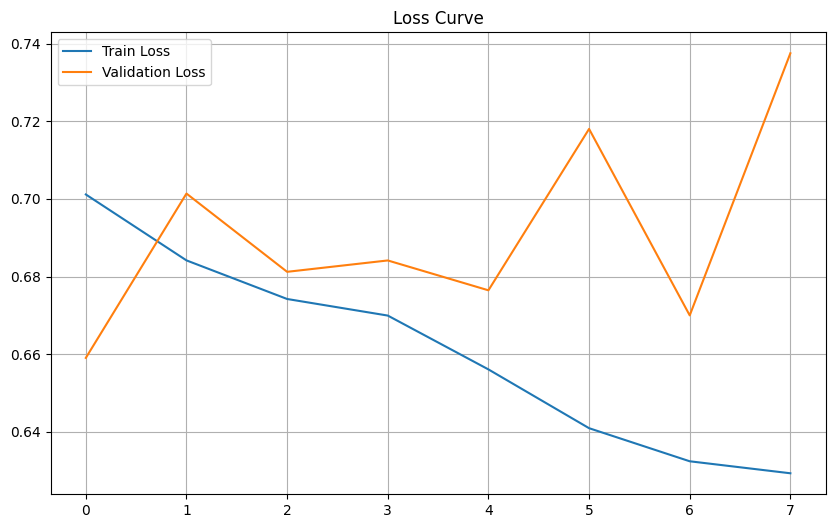


Final Test Metrics
Loss: 0.6961, Acc: 0.5928, F1: 0.5386, AUC: 0.6061


Testing: 100%|██████████| 70/70 [00:03<00:00, 19.92it/s]


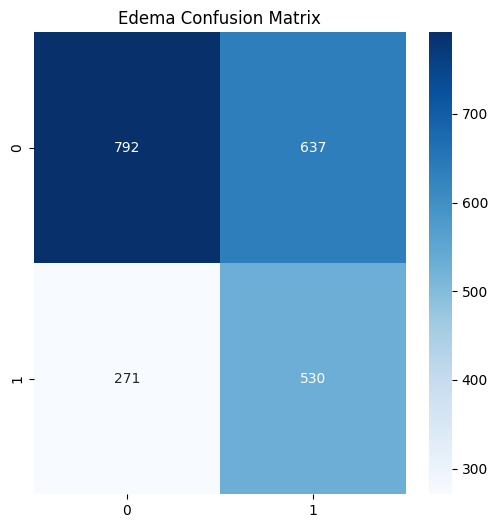

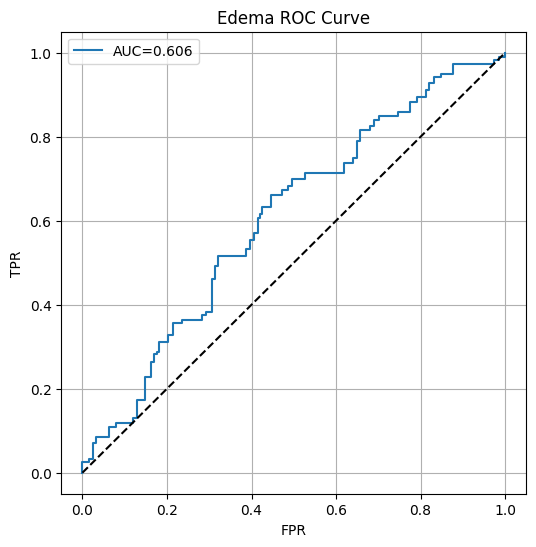


Classification Report:

              precision    recall  f1-score   support

    Negative       0.75      0.55      0.64      1429
    Positive       0.45      0.66      0.54       801

    accuracy                           0.59      2230
   macro avg       0.60      0.61      0.59      2230
weighted avg       0.64      0.59      0.60      2230



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm



# 1D RESNET MODEL
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class ECGResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * BasicBlock1D.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * BasicBlock1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock1D.expansion),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock1D.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)



# TRAIN & VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))



# MAIN TRAINING LOOP

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    target_class = "Edema"
    loaded_data = load_ecg_dataset(target_class)

    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGResNet1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)

        epoch_duration = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_resnet1d.pth')
            print(f"Saved best model with val AUC: {val_auc:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

    # Save history
    with open(f'{target_class}_ecg_resnet1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_resnet1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D ResNet - Lung Opacity

Epoch 5/15 | Time: 12.69s
Train -> Loss: 0.6644, Acc: 0.5957, F1: 0.5894, AUC: 0.6373
Val   -> Loss: 0.6729, Acc: 0.5971, F1: 0.6650, AUC: 0.6209


Early stopping.


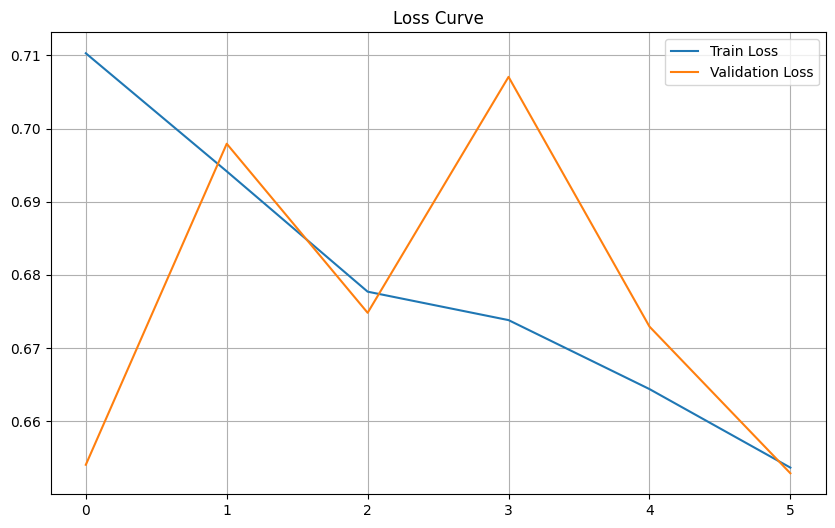


Final Test Metrics
Loss: 0.6850, Acc: 0.5285, F1: 0.5298, AUC: 0.6128


Testing: 100%|██████████| 67/67 [00:03<00:00, 19.55it/s]


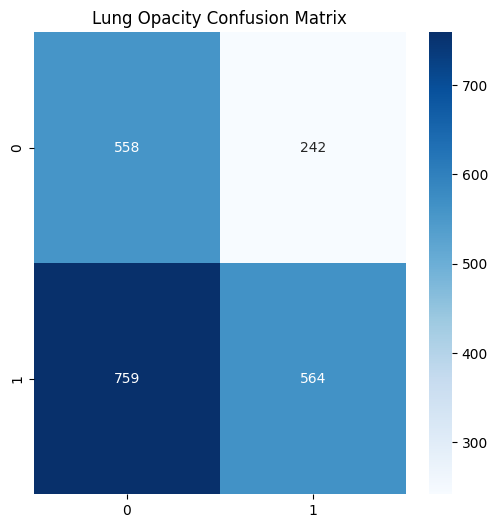

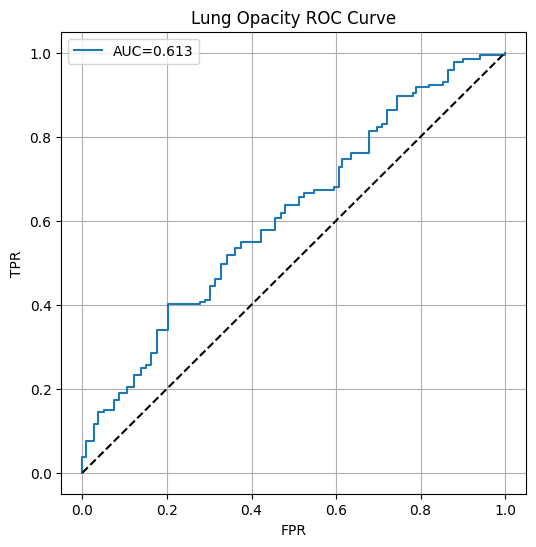


Classification Report:

              precision    recall  f1-score   support

    Negative       0.42      0.70      0.53       800
    Positive       0.70      0.43      0.53      1323

    accuracy                           0.53      2123
   macro avg       0.56      0.56      0.53      2123
weighted avg       0.60      0.53      0.53      2123



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output  # for Jupyter clearing


# 1D RESNET MODEL
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ECGResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * BasicBlock1D.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * BasicBlock1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock1D.expansion),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock1D.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS with tqdm bars
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Lung Opacity"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGResNet1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_resnet1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_resnet1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_resnet1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D ResNet - Pleural Effusion

Epoch 8/15 | Time: 19.55s
Train -> Loss: 0.6419, Acc: 0.6325, F1: 0.6321, AUC: 0.6845
Val   -> Loss: 0.6675, Acc: 0.5980, F1: 0.6359, AUC: 0.6584


Early stopping.


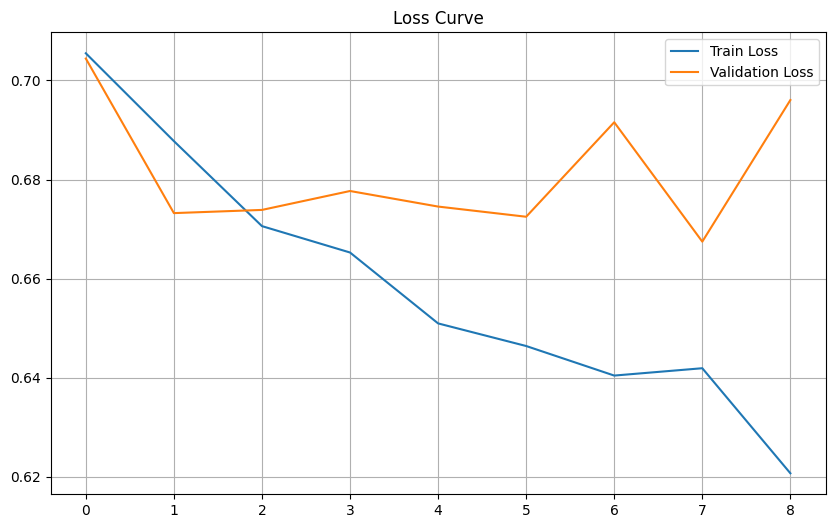


Final Test Metrics
Loss: 0.6652, Acc: 0.6245, F1: 0.6747, AUC: 0.6516


Testing: 100%|██████████| 99/99 [00:05<00:00, 17.83it/s]


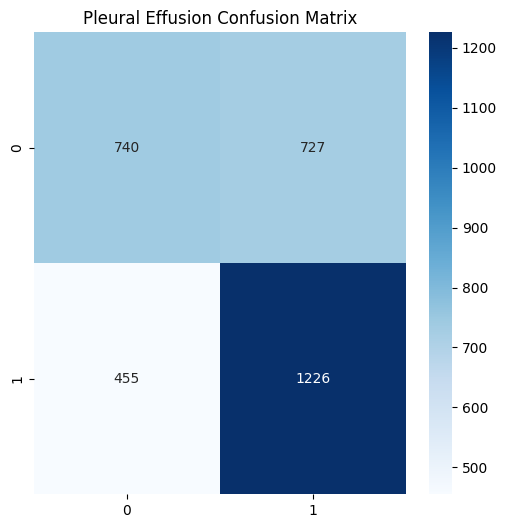

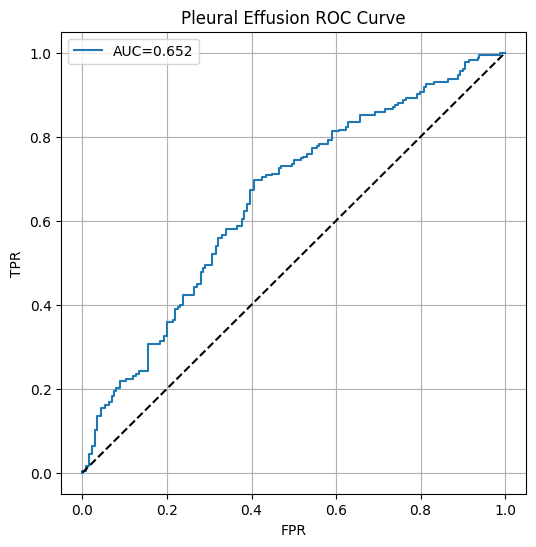


Classification Report:

              precision    recall  f1-score   support

    Negative       0.62      0.50      0.56      1467
    Positive       0.63      0.73      0.67      1681

    accuracy                           0.62      3148
   macro avg       0.62      0.62      0.62      3148
weighted avg       0.62      0.62      0.62      3148



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# 1D RESNET MODEL
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ECGResNet1D(nn.Module):
    def __init__(self, num_classes=1):
        super(ECGResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * BasicBlock1D.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock1D.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * BasicBlock1D.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock1D.expansion),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock1D.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Pleural Effusion"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = ECGResNet1D(num_classes=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_ecg_resnet1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    # Save history
    with open(f'{target_class}_ecg_resnet1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Plot losses
    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_ecg_resnet1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    # Confusion Matrix & ROC
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D InceptionTime - Atelectasis

Epoch 6/15 | Time: 72.20s
Train -> Loss: 0.6783, Acc: 0.5761, F1: 0.5708, AUC: 0.6021
Val   -> Loss: 0.7016, Acc: 0.5146, F1: 0.4908, AUC: 0.6055


Early stopping.


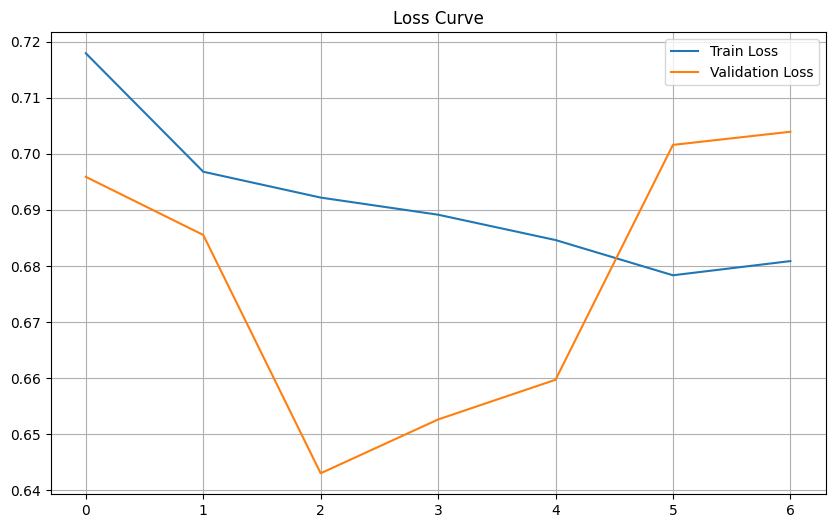


Final Test Metrics
Loss: 0.6780, Acc: 0.5352, F1: 0.6118, AUC: 0.5612


Testing: 100%|██████████| 67/67 [00:09<00:00,  7.04it/s]


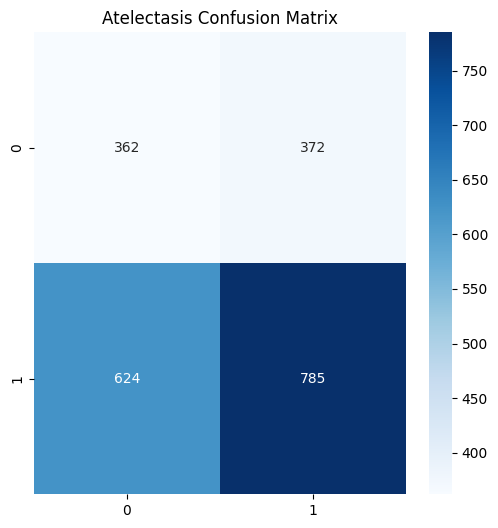

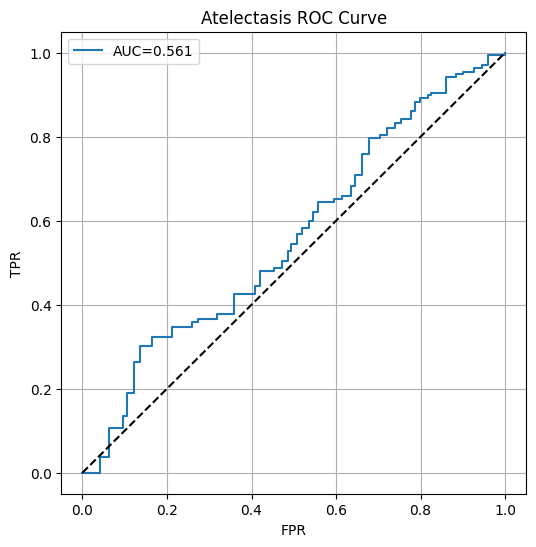


Classification Report:

              precision    recall  f1-score   support

    Negative       0.37      0.49      0.42       734
    Positive       0.68      0.56      0.61      1409

    accuracy                           0.54      2143
   macro avg       0.52      0.53      0.52      2143
weighted avg       0.57      0.54      0.55      2143



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# INCEPTIONTIME 1D MODEL
class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels=32, bottleneck_channels=32, kernel_sizes=[9,19,39]):
        super(InceptionBlock1D, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
            if in_channels > 1 else nn.Identity()

        self.conv_list = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels,
                      out_channels, kernel_size=k, stride=1,
                      padding=k//2, bias=False)
            for k in kernel_sizes
        ])

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        out = [conv(x_bottleneck) for conv in self.conv_list]
        out.append(self.conv_pool(self.pool(x)))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, out_channels=32):
        super(InceptionModule1D, self).__init__()
        blocks = []
        for i in range(num_blocks):
            blocks.append(InceptionBlock1D(
                in_channels if i==0 else out_channels*4,
                out_channels=out_channels
            ))
        self.blocks = nn.Sequential(*blocks)

        self.residual = nn.Conv1d(in_channels, out_channels*4, kernel_size=1, bias=False) \
            if in_channels != out_channels*4 else nn.Identity()
        self.bn = nn.BatchNorm1d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.blocks(x)
        res = self.residual(x)
        return self.relu(out + self.bn(res))


class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=1, in_channels=12):
        super(InceptionTime1D, self).__init__()
        self.inception1 = InceptionModule1D(in_channels, num_blocks=3, out_channels=32)
        self.inception2 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)
        self.inception3 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32*4, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Atelectasis"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Use InceptionTime model
    model = InceptionTime1D(num_classes=1, in_channels=12).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_inceptiontime1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    with open(f'{target_class}_inceptiontime1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_inceptiontime1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D InceptionTime - Cardiomegaly

Epoch 5/15 | Time: 90.02s
Train -> Loss: 0.6480, Acc: 0.6275, F1: 0.6328, AUC: 0.6748
Val   -> Loss: 0.7064, Acc: 0.5586, F1: 0.5847, AUC: 0.6030


Early stopping.


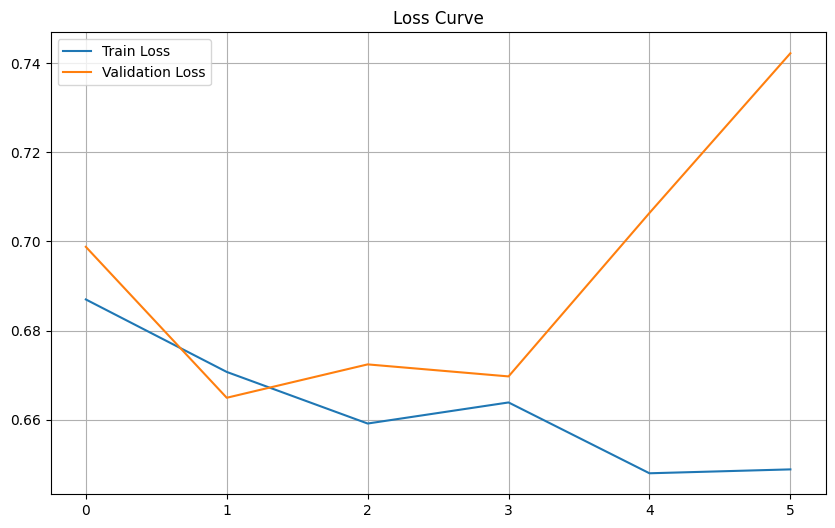


Final Test Metrics
Loss: 0.6797, Acc: 0.5538, F1: 0.5453, AUC: 0.6260


Testing: 100%|██████████| 80/80 [00:11<00:00,  7.09it/s]


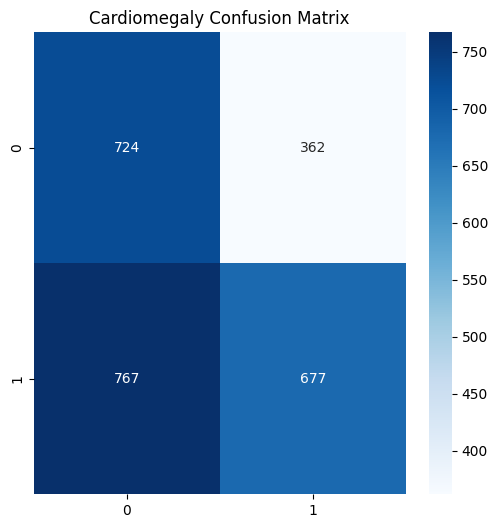

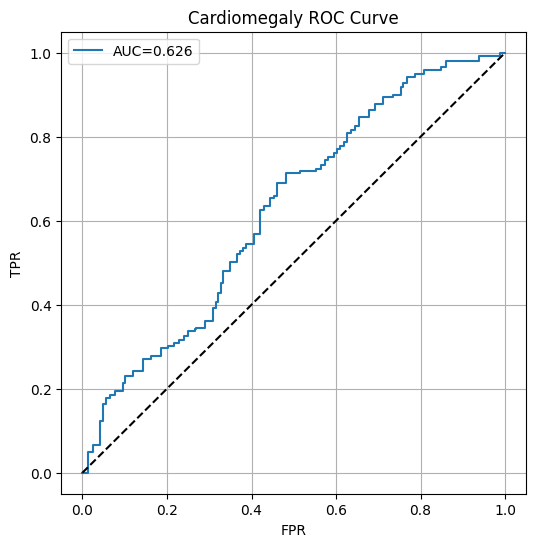


Classification Report:

              precision    recall  f1-score   support

    Negative       0.49      0.67      0.56      1086
    Positive       0.65      0.47      0.55      1444

    accuracy                           0.55      2530
   macro avg       0.57      0.57      0.55      2530
weighted avg       0.58      0.55      0.55      2530



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# INCEPTIONTIME 1D MODEL
class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels=32, bottleneck_channels=32, kernel_sizes=[9,19,39]):
        super(InceptionBlock1D, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
            if in_channels > 1 else nn.Identity()

        self.conv_list = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels,
                      out_channels, kernel_size=k, stride=1,
                      padding=k//2, bias=False)
            for k in kernel_sizes
        ])

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        out = [conv(x_bottleneck) for conv in self.conv_list]
        out.append(self.conv_pool(self.pool(x)))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, out_channels=32):
        super(InceptionModule1D, self).__init__()
        blocks = []
        for i in range(num_blocks):
            blocks.append(InceptionBlock1D(
                in_channels if i==0 else out_channels*4,
                out_channels=out_channels
            ))
        self.blocks = nn.Sequential(*blocks)

        self.residual = nn.Conv1d(in_channels, out_channels*4, kernel_size=1, bias=False) \
            if in_channels != out_channels*4 else nn.Identity()
        self.bn = nn.BatchNorm1d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.blocks(x)
        res = self.residual(x)
        return self.relu(out + self.bn(res))


class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=1, in_channels=12):
        super(InceptionTime1D, self).__init__()
        self.inception1 = InceptionModule1D(in_channels, num_blocks=3, out_channels=32)
        self.inception2 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)
        self.inception3 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32*4, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Cardiomegaly"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = InceptionTime1D(num_classes=1, in_channels=12).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_inceptiontime1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    with open(f'{target_class}_inceptiontime1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_inceptiontime1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D InceptionTime - Edema

Epoch 4/15 | Time: 83.10s
Train -> Loss: 0.6820, Acc: 0.5688, F1: 0.5494, AUC: 0.5933
Val   -> Loss: 0.6681, Acc: 0.6343, F1: 0.5017, AUC: 0.6114


Early stopping.


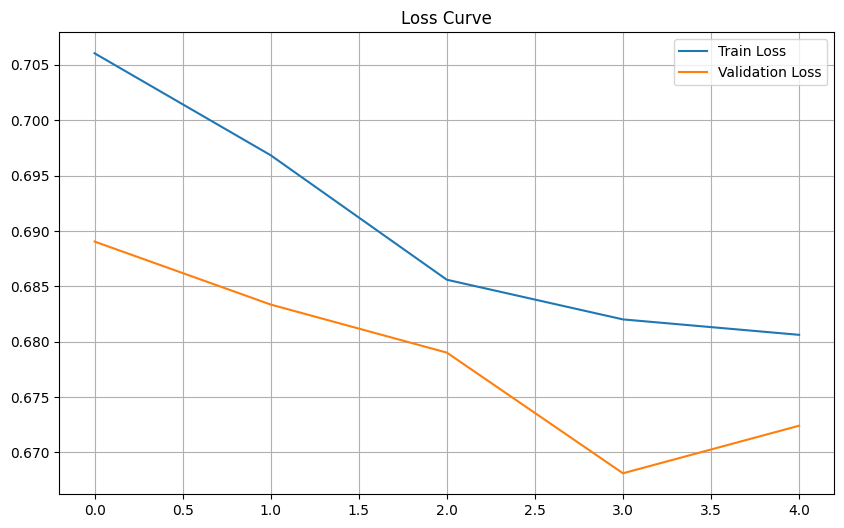


Final Test Metrics
Loss: 0.7132, Acc: 0.5964, F1: 0.5208, AUC: 0.6121


Testing: 100%|██████████| 70/70 [00:09<00:00,  7.06it/s]


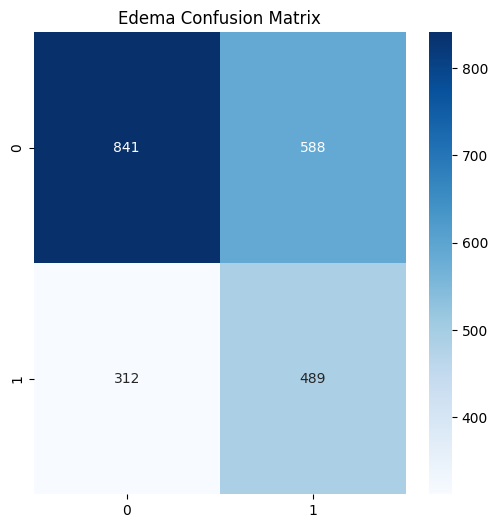

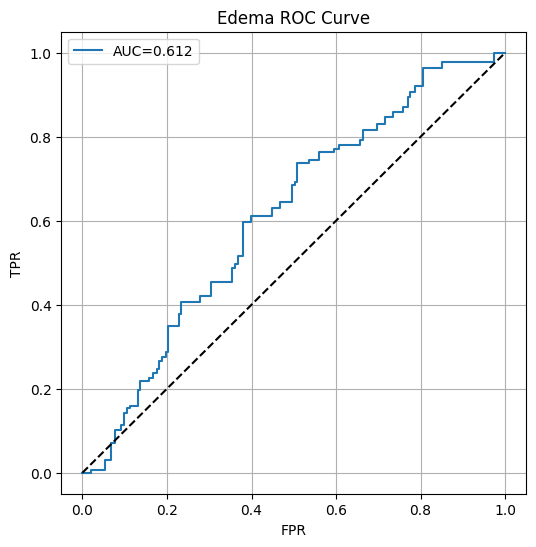


Classification Report:

              precision    recall  f1-score   support

    Negative       0.73      0.59      0.65      1429
    Positive       0.45      0.61      0.52       801

    accuracy                           0.60      2230
   macro avg       0.59      0.60      0.59      2230
weighted avg       0.63      0.60      0.60      2230



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output
# INCEPTIONTIME 1D MODEL
class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels=32, bottleneck_channels=32, kernel_sizes=[9,19,39]):
        super(InceptionBlock1D, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
            if in_channels > 1 else nn.Identity()

        self.conv_list = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels,
                      out_channels, kernel_size=k, stride=1,
                      padding=k//2, bias=False)
            for k in kernel_sizes
        ])

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        out = [conv(x_bottleneck) for conv in self.conv_list]
        out.append(self.conv_pool(self.pool(x)))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, out_channels=32):
        super(InceptionModule1D, self).__init__()
        blocks = []
        for i in range(num_blocks):
            blocks.append(InceptionBlock1D(
                in_channels if i==0 else out_channels*4,
                out_channels=out_channels
            ))
        self.blocks = nn.Sequential(*blocks)

        self.residual = nn.Conv1d(in_channels, out_channels*4, kernel_size=1, bias=False) \
            if in_channels != out_channels*4 else nn.Identity()
        self.bn = nn.BatchNorm1d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.blocks(x)
        res = self.residual(x)
        return self.relu(out + self.bn(res))


class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=1, in_channels=12):
        super(InceptionTime1D, self).__init__()
        self.inception1 = InceptionModule1D(in_channels, num_blocks=3, out_channels=32)
        self.inception2 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)
        self.inception3 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32*4, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Edema"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Use InceptionTime model
    model = InceptionTime1D(num_classes=1, in_channels=12).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_inceptiontime1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    with open(f'{target_class}_inceptiontime1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_inceptiontime1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D InceptionTime - Lung Opacity

Epoch 3/15 | Time: 76.96s
Train -> Loss: 0.6936, Acc: 0.5359, F1: 0.5416, AUC: 0.5509
Val   -> Loss: 0.6961, Acc: 0.5382, F1: 0.5675, AUC: 0.5834


Early stopping.


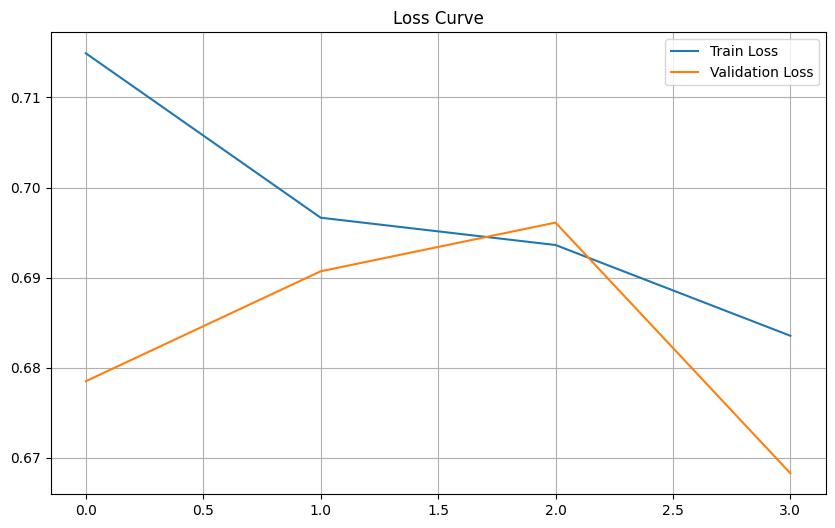


Final Test Metrics
Loss: 0.6835, Acc: 0.5313, F1: 0.5300, AUC: 0.5960


Testing: 100%|██████████| 67/67 [00:09<00:00,  7.07it/s]


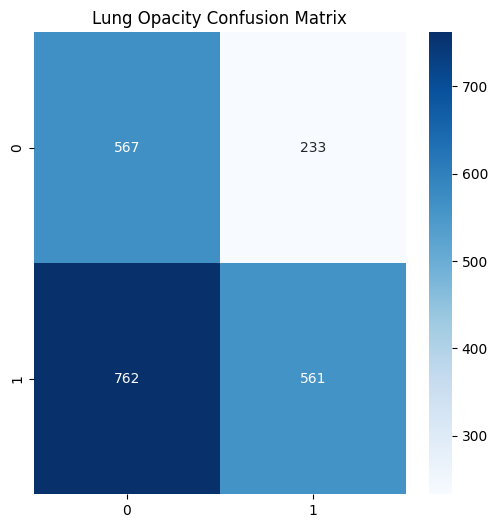

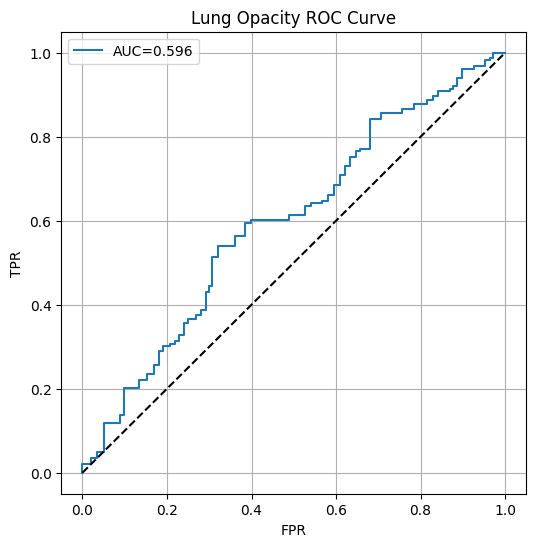


Classification Report:

              precision    recall  f1-score   support

    Negative       0.43      0.71      0.53       800
    Positive       0.71      0.42      0.53      1323

    accuracy                           0.53      2123
   macro avg       0.57      0.57      0.53      2123
weighted avg       0.60      0.53      0.53      2123



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# INCEPTIONTIME 1D MODEL

class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels=32, bottleneck_channels=32, kernel_sizes=[9,19,39]):
        super(InceptionBlock1D, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
            if in_channels > 1 else nn.Identity()

        self.conv_list = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels,
                      out_channels, kernel_size=k, stride=1,
                      padding=k//2, bias=False)
            for k in kernel_sizes
        ])

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        out = [conv(x_bottleneck) for conv in self.conv_list]
        out.append(self.conv_pool(self.pool(x)))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, out_channels=32):
        super(InceptionModule1D, self).__init__()
        blocks = []
        for i in range(num_blocks):
            blocks.append(InceptionBlock1D(
                in_channels if i==0 else out_channels*4,
                out_channels=out_channels
            ))
        self.blocks = nn.Sequential(*blocks)

        self.residual = nn.Conv1d(in_channels, out_channels*4, kernel_size=1, bias=False) \
            if in_channels != out_channels*4 else nn.Identity()
        self.bn = nn.BatchNorm1d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.blocks(x)
        res = self.residual(x)
        return self.relu(out + self.bn(res))


class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=1, in_channels=12):
        super(InceptionTime1D, self).__init__()
        self.inception1 = InceptionModule1D(in_channels, num_blocks=3, out_channels=32)
        self.inception2 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)
        self.inception3 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32*4, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))


# MAIN TRAINING LOOP
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Lung Opacity"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Use InceptionTime model
    model = InceptionTime1D(num_classes=1, in_channels=12).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_inceptiontime1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    with open(f'{target_class}_inceptiontime1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING

    model.load_state_dict(torch.load(f'best_{target_class}_inceptiontime1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))


# 1D InceptionTime - Pleural Efussion

Epoch 9/15 | Time: 107.42s
Train -> Loss: 0.6672, Acc: 0.5951, F1: 0.6106, AUC: 0.6312
Val   -> Loss: 0.6667, Acc: 0.6041, F1: 0.6473, AUC: 0.6387


Early stopping.


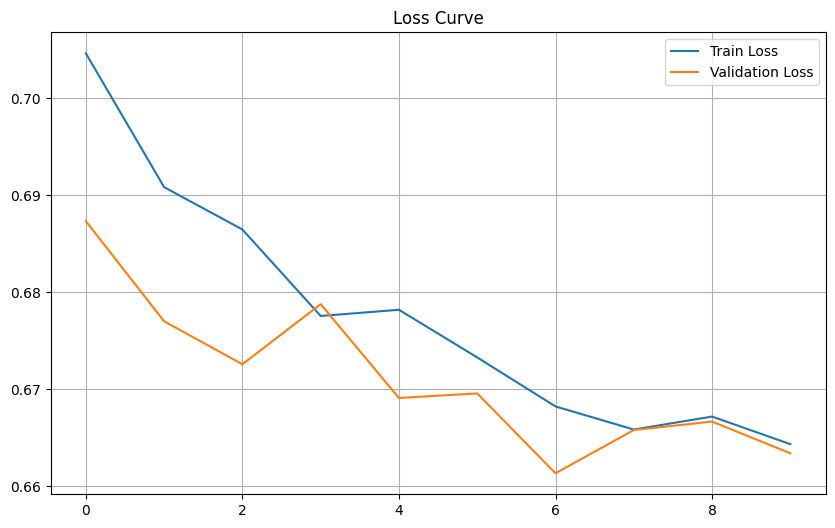


Final Test Metrics
Loss: 0.6664, Acc: 0.5874, F1: 0.6077, AUC: 0.6402


Testing: 100%|██████████| 99/99 [00:14<00:00,  6.99it/s]


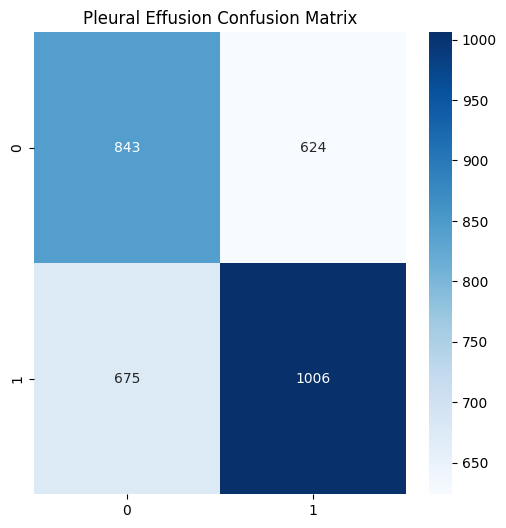

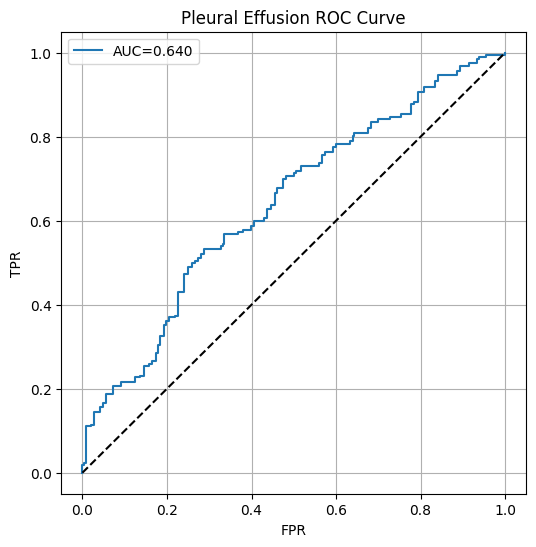


Classification Report:

              precision    recall  f1-score   support

    Negative       0.56      0.57      0.56      1467
    Positive       0.62      0.60      0.61      1681

    accuracy                           0.59      3148
   macro avg       0.59      0.59      0.59      3148
weighted avg       0.59      0.59      0.59      3148



In [ ]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from tqdm import tqdm
from IPython.display import clear_output

# INCEPTIONTIME 1D MODEL

class InceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels=32, bottleneck_channels=32, kernel_sizes=[9,19,39]):
        super(InceptionBlock1D, self).__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
            if in_channels > 1 else nn.Identity()

        self.conv_list = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels,
                      out_channels, kernel_size=k, stride=1,
                      padding=k//2, bias=False)
            for k in kernel_sizes
        ])

        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_pool = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        out = [conv(x_bottleneck) for conv in self.conv_list]
        out.append(self.conv_pool(self.pool(x)))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, num_blocks=3, out_channels=32):
        super(InceptionModule1D, self).__init__()
        blocks = []
        for i in range(num_blocks):
            blocks.append(InceptionBlock1D(
                in_channels if i==0 else out_channels*4,
                out_channels=out_channels
            ))
        self.blocks = nn.Sequential(*blocks)

        self.residual = nn.Conv1d(in_channels, out_channels*4, kernel_size=1, bias=False) \
            if in_channels != out_channels*4 else nn.Identity()
        self.bn = nn.BatchNorm1d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.blocks(x)
        res = self.residual(x)
        return self.relu(out + self.bn(res))


class InceptionTime1D(nn.Module):
    def __init__(self, num_classes=1, in_channels=12):
        super(InceptionTime1D, self).__init__()
        self.inception1 = InceptionModule1D(in_channels, num_blocks=3, out_channels=32)
        self.inception2 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)
        self.inception3 = InceptionModule1D(32*4, num_blocks=3, out_channels=32)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32*4, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# TRAIN & VALIDATION FUNCTIONS

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Training", leave=False, colour="blue")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        trues.extend(labels.cpu().numpy())

        loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, preds, trues = 0.0, [], []

    loop = tqdm(loader, desc="Validating", leave=False, colour="green")
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.cpu().numpy())

            loop.set_postfix(loss=running_loss/((loop.n+1)*inputs.size(0)))

    preds = np.array(preds).squeeze()
    trues = np.array(trues)
    return (running_loss / len(loader.dataset),
            accuracy_score(trues, (preds > 0.5).astype(int)),
            f1_score(trues, (preds > 0.5).astype(int)),
            roc_auc_score(trues, preds))

# MAIN TRAINING LOOP

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load your dataset here
    target_class = "Pleural Effusion"
    loaded_data = load_ecg_dataset(target_class)
    train_dataset = ECGDataset(loaded_data['train']['df'], loaded_data['train']['ecg_paths'], target_class)
    val_dataset = ECGDataset(loaded_data['val']['df'], loaded_data['val']['ecg_paths'], target_class)
    test_dataset = ECGDataset(loaded_data['test']['df'], loaded_data['test']['ecg_paths'], target_class)

    labels = loaded_data['train']['df'][target_class].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Use InceptionTime model
    model = InceptionTime1D(num_classes=1, in_channels=12).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)

    num_epochs = 15
    best_val_auc = 0
    patience, epochs_no_improve = 3, 0
    history = {k: [] for k in ['train_loss','train_acc','train_f1','train_auc',
                               'val_loss','val_acc','val_f1','val_auc','epoch_time']}

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc, train_f1, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = validate(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time

        for k,v in zip(history.keys(), [train_loss,train_acc,train_f1,train_auc,
                                        val_loss,val_acc,val_f1,val_auc,epoch_duration]):
            history[k].append(v)

        if val_auc > best_val_auc:
            best_val_auc, epochs_no_improve = val_auc, 0
            torch.save(model.state_dict(), f'best_{target_class}_inceptiontime1d.pth')
            best_msg = f"Saved best model with val AUC: {val_auc:.4f}"
        else:
            epochs_no_improve += 1
            best_msg = ""
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s")
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        if best_msg:
            print(best_msg)

    with open(f'{target_class}_inceptiontime1d_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    plt.figure(figsize=(10,6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(); plt.grid(); plt.title("Loss Curve")
    plt.savefig(f"{target_class}_loss_curve.png"); plt.show()

    # TESTING
    model.load_state_dict(torch.load(f'best_{target_class}_inceptiontime1d.pth'))
    model.eval()
    test_loss, test_acc, test_f1, test_auc = validate(model, test_loader, criterion, device)

    print("\nFinal Test Metrics")
    print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", colour="cyan"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs)).cpu().numpy().squeeze()
            preds = (outputs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs)

    y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{target_class} Confusion Matrix"); plt.savefig("confusion_matrix.png"); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{target_class} ROC Curve")
    plt.legend(); plt.grid(); plt.savefig("roc_curve.png"); plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))
